## Week-1

### 1. Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR
import warnings

### 2. Importing the datasets

In [2]:
sales_data    = pd.read_excel("ProductA.xlsx")
google_clicks = pd.read_excel("ProductA_google_clicks.xlsx")
impressions   = pd.read_excel("ProductA_fb_impressions.xlsx")

### 3. Merging datasets

In [3]:
data    = pd.merge(sales_data, google_clicks, on="Day Index", how="left")
dataset = pd.merge(data, impressions, on="Day Index", how="left")

In [4]:
dataset.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678


### 4. Descriptive Statistics

In [5]:
# Shape of the data in rows & columns

rows,columns = dataset.shape

print("Total number of rows : ",rows)
print("Total number of columns : ",columns)

Total number of rows :  212
Total number of columns :  4


In [6]:
# Basic info and structure
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 8.3 KB


In [7]:
dataset.columns

Index(['Day Index', 'Quantity', 'Clicks', 'Impressions'], dtype='object')

In [8]:
# Data type of each column
dataset.dtypes

Day Index      datetime64[ns]
Quantity                int64
Clicks                  int64
Impressions             int64
dtype: object

In [9]:
# Basic statistics for numerical columns
dataset.describe()

,Quantity,Clicks,Impressions
count,212.000000,212.00000,212.000000
mean,17.542453,358.20283,1531.702830
std,5.790423,164.52160,440.660783
min,5.000000,60.00000,620.000000
25%,13.750000,154.00000,1209.750000
50%,17.000000,402.50000,1460.000000
75%,21.000000,492.75000,1862.000000
max,38.000000,726.00000,2707.000000


## Week-2

## EXPLORATORY DATA ANALYSIS

### 5. Handling missing values

In [10]:
# Check for missing values in the dataset
print(dataset.isnull().sum())

Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64


=> There are no missing values in the dataset

### 6. Data visualisation

Text(0.5, 1.0, 'Day Index Vs Quantity')

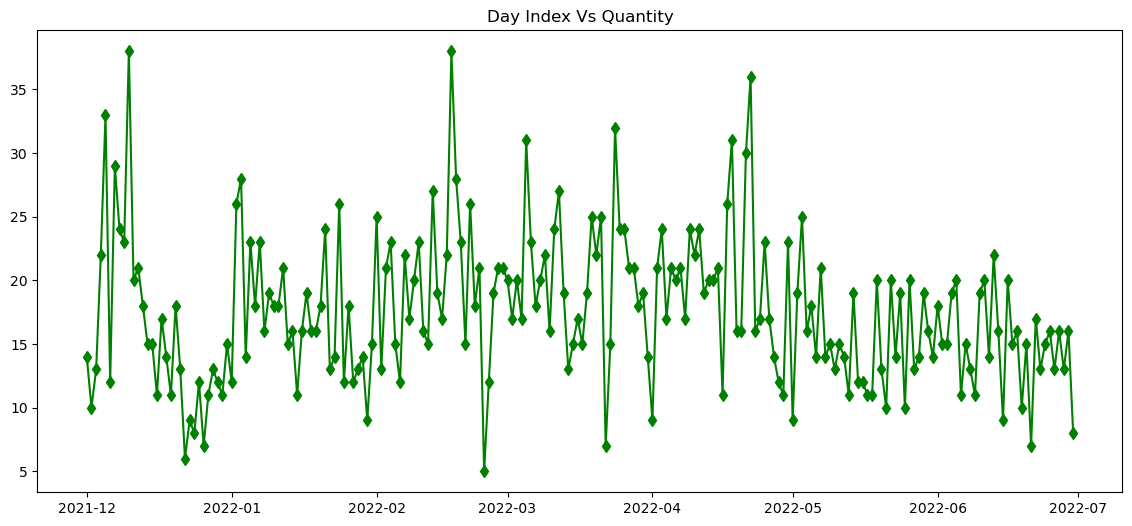

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(dataset['Day Index'],dataset['Quantity'],marker='d',c='green')
plt.title("Day Index Vs Quantity")

    ➡️There are more sales in the months of December, March, May

Text(0.5, 1.0, 'Day Index Vs Impressions')

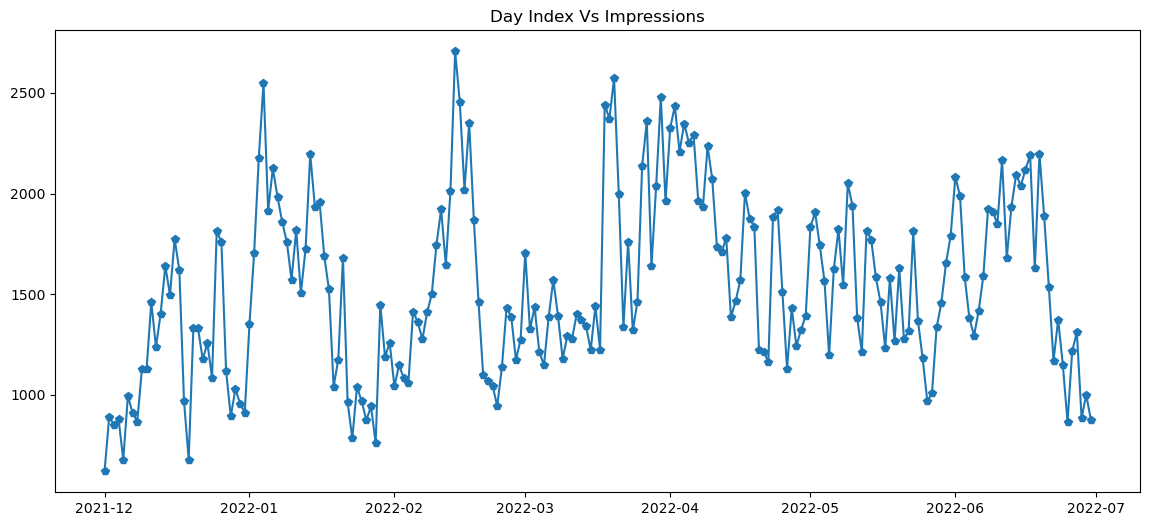

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(dataset['Day Index'],dataset['Impressions'],marker='p')
plt.title("Day Index Vs Impressions")

    The graph shows daily fluctuations in impressions, with notable peaks around January and April 2022, indicating periodic increases in activity.

Text(0.5, 1.0, 'Day Index Vs Clicks')

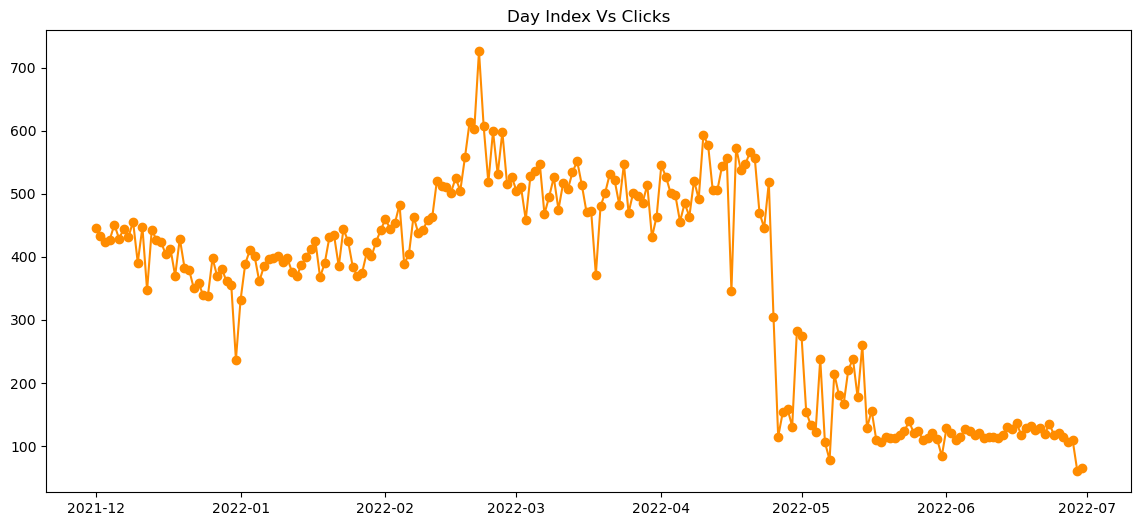

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(dataset['Day Index'],dataset['Clicks'],marker='o',c='darkorange')
plt.title("Day Index Vs Clicks")

    The plot shows a steady increase in clicks until may-2022, followed by a sharp decline.

### 7.Detecting Outliers

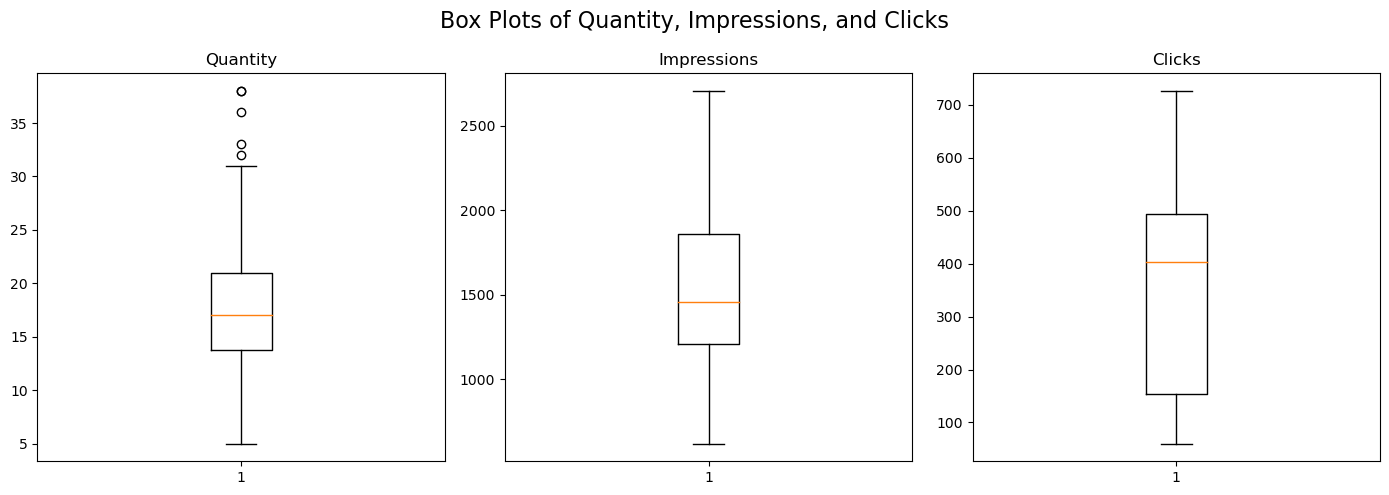

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

ax[0].boxplot(dataset['Quantity'])
ax[0].set_title("Quantity")

ax[1].boxplot(dataset['Impressions'])
ax[1].set_title("Impressions")

ax[2].boxplot(dataset['Clicks'])
ax[2].set_title("Clicks")

fig.suptitle("Box Plots of Quantity, Impressions, and Clicks", fontsize=16)
plt.tight_layout()
plt.show()

     ➡️There are outliers only in Quantity attribute

### 8.Handling Outliers

In [15]:
def count_outliers(df):
    outlier_counts = {}
    for i in df.select_dtypes(include=['float64', 'int64']):
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[i] < lower_bound) | (df[i] > upper_bound)]
        outlier_counts[i] = len(outliers)
    return outlier_counts


outliers = count_outliers(dataset)
print("Number of outliers in each column\n")
for i in outliers:
    print(i," : ",outliers[i])

Number of outliers in each column

Quantity  :  5
Clicks  :  0
Impressions  :  0


In [16]:
percentile=dataset['Quantity'].quantile(0.95)
print("95th percentile value : ",percentile)

95th percentile value :  27.44999999999999


In [17]:
def update_outliers(data):
    q1,q3=data.quantile([0.25,0.75])
    IQR=q3-q1
    lower,upper=q1-(1.5*IQR), q3+(1.5*IQR)
    return data.apply(lambda x: percentile if x<lower or x>upper else x)

In [18]:
df=dataset.copy()
df['Quantity']=update_outliers(df['Quantity'])
print("Updated Data : ")
df

Updated Data : 


,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14.00,445,620
1,2021-12-02,10.00,433,890
2,2021-12-03,13.00,424,851
3,2021-12-04,22.00,427,881
4,2021-12-05,27.45,451,678
...,...,...,...,...
207,2022-06-26,13.00,114,1218
208,2022-06-27,16.00,106,1311
209,2022-06-28,13.00,109,885
210,2022-06-29,16.00,60,1000


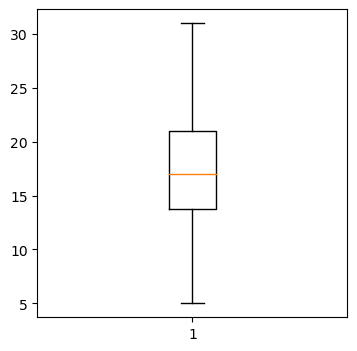

In [19]:
plt.figure(figsize=(4,4))
plt.boxplot(df['Quantity'])
plt.show()

    Therefore, Outliers are replaced by 95th percentile values.

# Feature Engineering

* Extracting year and month from Day Index

In [20]:
df['Year-Month'] = df['Day Index'].dt.to_period('M')

* Extracting Month names and Month number

In [21]:
df['MonthName'] = df['Day Index'].dt.month_name()
df['MonthName'] = pd.Categorical(df['MonthName'], categories=['December', 'January', 'February', 'March', 'April', 'May', 'June'], ordered=True)
df['MonthNumber'] = df['Day Index'].dt.month
# df.head()

* Extracting day of the week and No.of week in Month

In [22]:
df['Day_of_week'] = df['Day Index'].dt.day_name()
df['Day_of_week'] = pd.Categorical(df['Day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)
df['Day_number'] = df['Day Index'].dt.weekday+1

def weekOfMonth(date):
    first_day = date.replace(day=1)
    date = date.day + first_day.weekday()
    return int(np.ceil(date/7.0))

df['Week_of_Month'] = df['Day Index'].apply(weekOfMonth)

* Checking whether a day is weekend or week day

In [23]:
df['Weekend'] = (df['Day Index'].dt.weekday > 4).astype(int)
# df['Week_day'] = (df['Day Index'].dt.weekday < 5).astype(int)

* Extracting months and adding to dataset

In [24]:
months=['December','January','February','March','April','May','June']
month_num=[12,1,2,3,4,5,6]
for i in range(len(months)):
    df[months[i]] = (df['MonthNumber'] == month_num[i]).astype(int)

df.head()

,Day Index,Quantity,Clicks,Impressions,Year-Month,MonthName,MonthNumber,Day_of_week,Day_number,Week_of_Month,Weekend,December,January,February,March,April,May,June
0,2021-12-01,14.00,445,620,2021-12,December,12,Wednesday,3,1,0,1,0,0,0,0,0,0
1,2021-12-02,10.00,433,890,2021-12,December,12,Thursday,4,1,0,1,0,0,0,0,0,0
2,2021-12-03,13.00,424,851,2021-12,December,12,Friday,5,1,0,1,0,0,0,0,0,0
3,2021-12-04,22.00,427,881,2021-12,December,12,Saturday,6,1,1,1,0,0,0,0,0,0
4,2021-12-05,27.45,451,678,2021-12,December,12,Sunday,7,1,1,1,0,0,0,0,0,0


<br></br>
* Extracting days and adding to dataset

In [25]:
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(len(days)):
    df[days[i]] = (df['Day_number']-1 == i).astype(int)

df.head()

,Day Index,Quantity,Clicks,Impressions,Year-Month,MonthName,MonthNumber,Day_of_week,Day_number,Week_of_Month,...,April,May,June,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2021-12-01,14.00,445,620,2021-12,December,12,Wednesday,3,1,...,0,0,0,0,0,1,0,0,0,0
1,2021-12-02,10.00,433,890,2021-12,December,12,Thursday,4,1,...,0,0,0,0,0,0,1,0,0,0
2,2021-12-03,13.00,424,851,2021-12,December,12,Friday,5,1,...,0,0,0,0,0,0,0,1,0,0
3,2021-12-04,22.00,427,881,2021-12,December,12,Saturday,6,1,...,0,0,0,0,0,0,0,0,1,0
4,2021-12-05,27.45,451,678,2021-12,December,12,Sunday,7,1,...,0,0,0,0,0,0,0,0,0,1


In [26]:
df.columns

Index(['Day Index', 'Quantity', 'Clicks', 'Impressions', 'Year-Month',
       'MonthName', 'MonthNumber', 'Day_of_week', 'Day_number',
       'Week_of_Month', 'Weekend', 'December', 'January', 'February', 'March',
       'April', 'May', 'June', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday'],
      dtype='object')

### 9.Corelation between Features

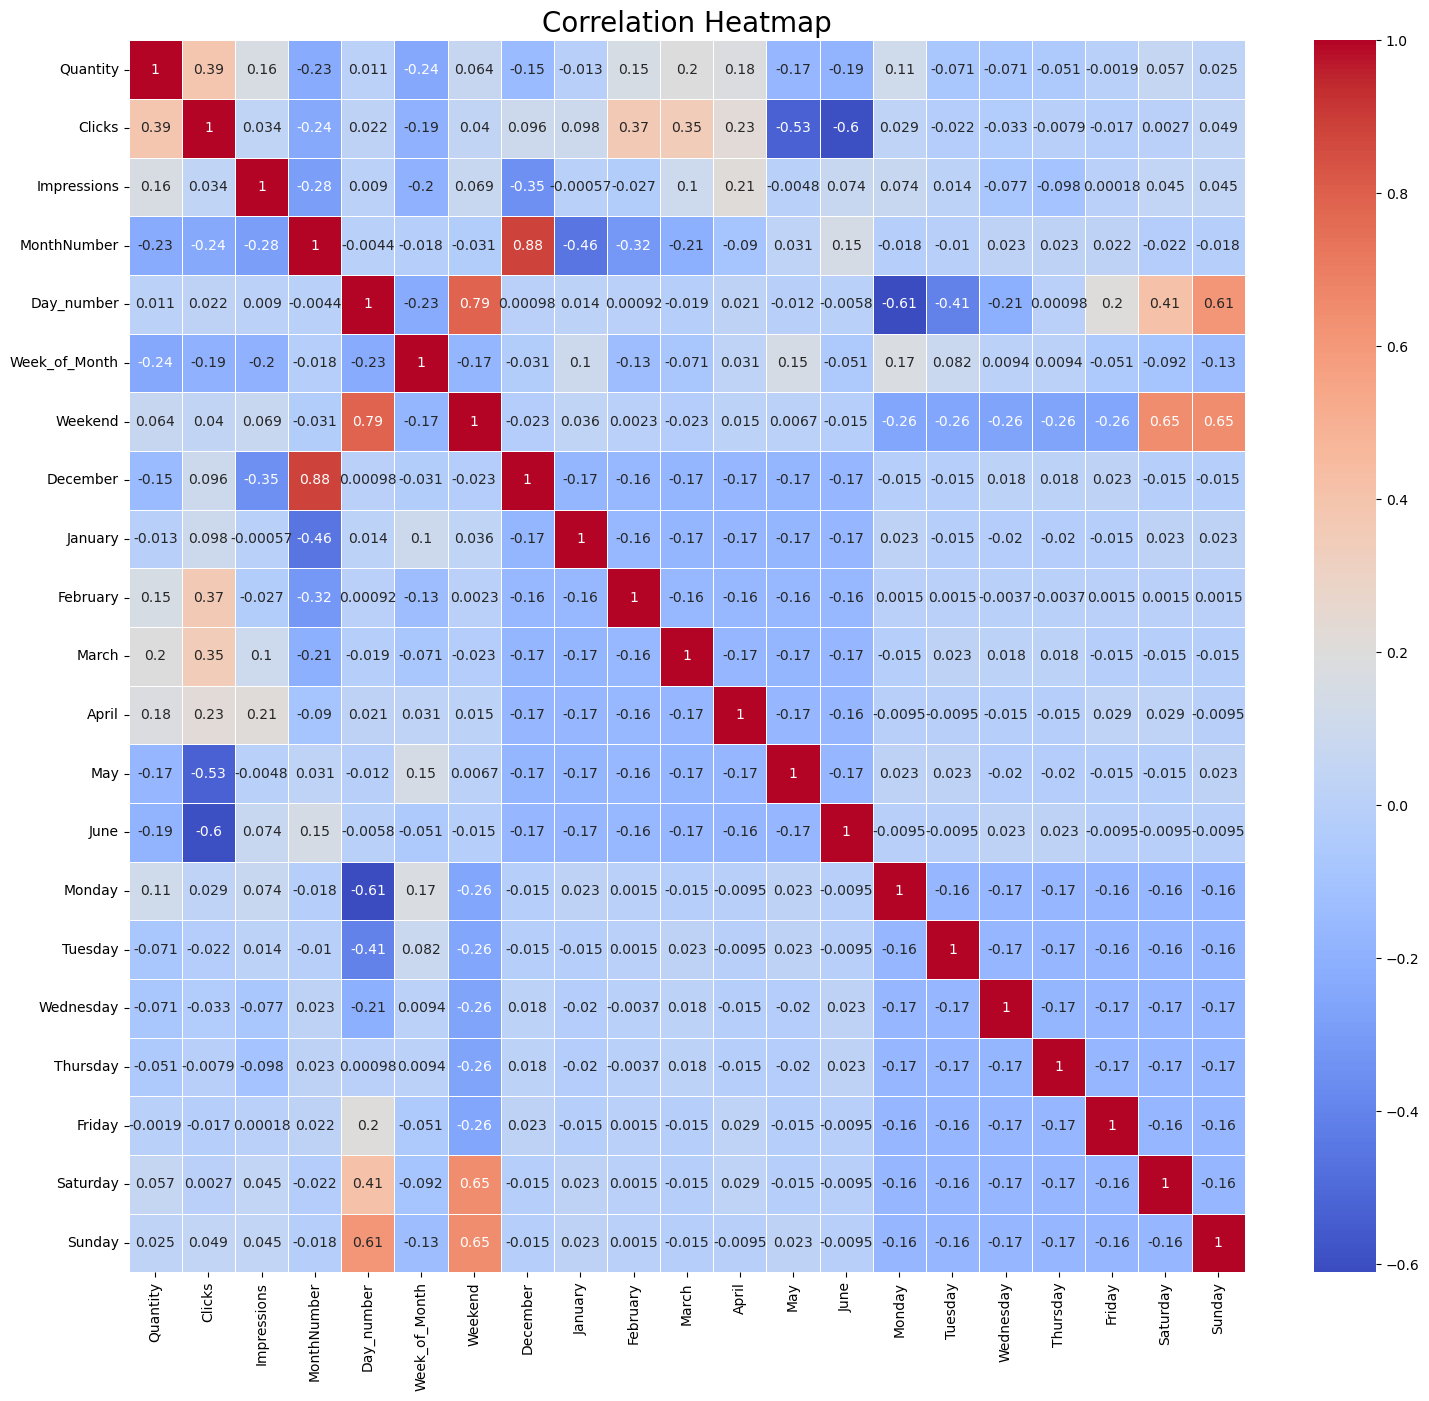

In [27]:
plt.figure(figsize=(18,16))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap="coolwarm",linewidths=0.5).set_title("Correlation Heatmap",fontsize=20)
plt.show()

    The heatmap shows a positive correlation between Quantity and Clicks

### Day wise plots

#### i. For Quantity

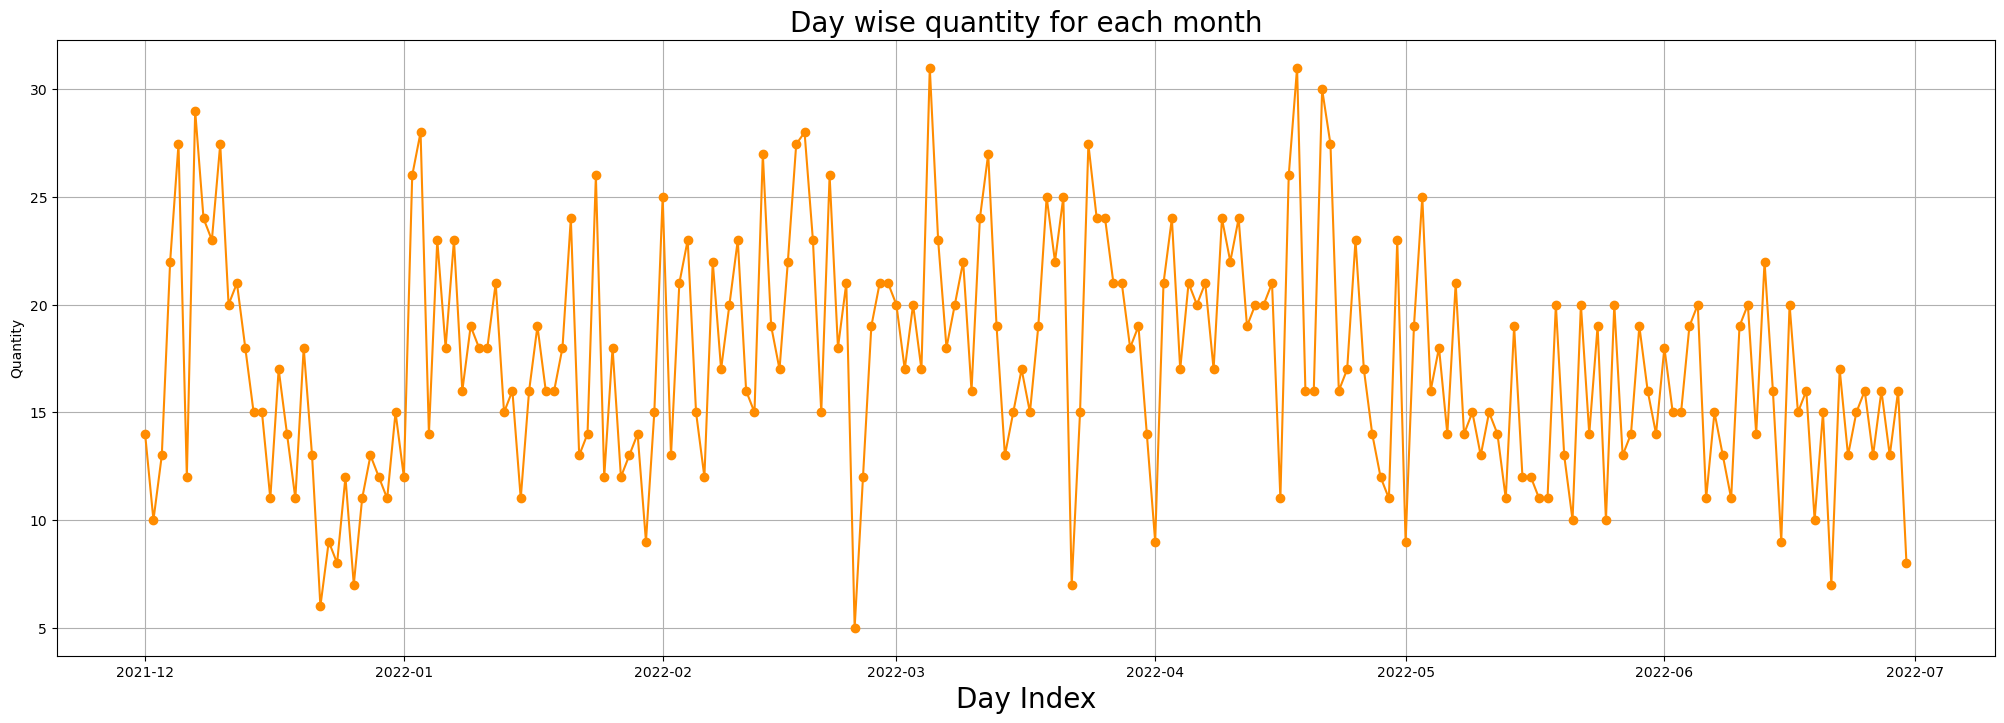

In [28]:
plt.figure(figsize=(25,8))
# plt.plot(dataset['Day Index'],dataset['Quantity'],color='purple')
plt.plot(df['Day Index'],df['Quantity'],marker='o',color='darkorange')
    
plt.title('Day wise quantity for each month',fontsize=20)
plt.xlabel('Day Index',fontsize=20)
plt.ylabel('Quantity')
plt.grid(True)
plt.show()  

    ➡️There are more sales in the months of December, March,April and May

#### ii. For Clicks

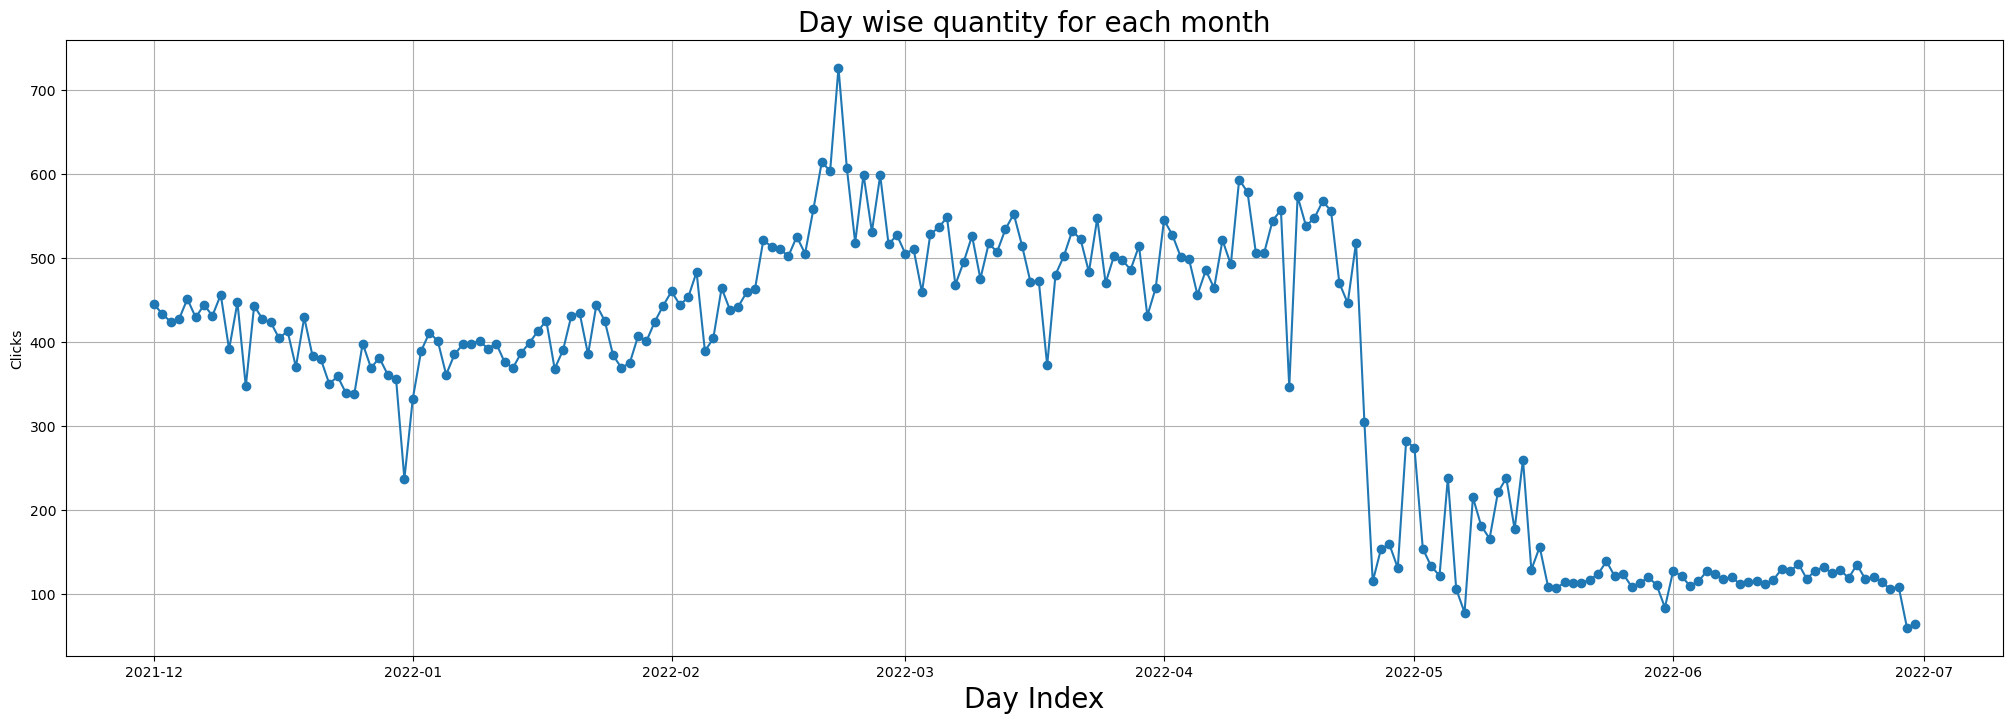

In [29]:
plt.figure(figsize=(25,8))

plt.plot(df['Day Index'],df['Clicks'],marker='o')
    
plt.title('Day wise quantity for each month',fontsize=20)
plt.xlabel('Day Index',fontsize=20)
plt.ylabel('Clicks')
plt.grid(True)
plt.show()

    ➡️There is steady increase in clicks until may-2022, followed by a sharp decline.

#### iii. For Impressions

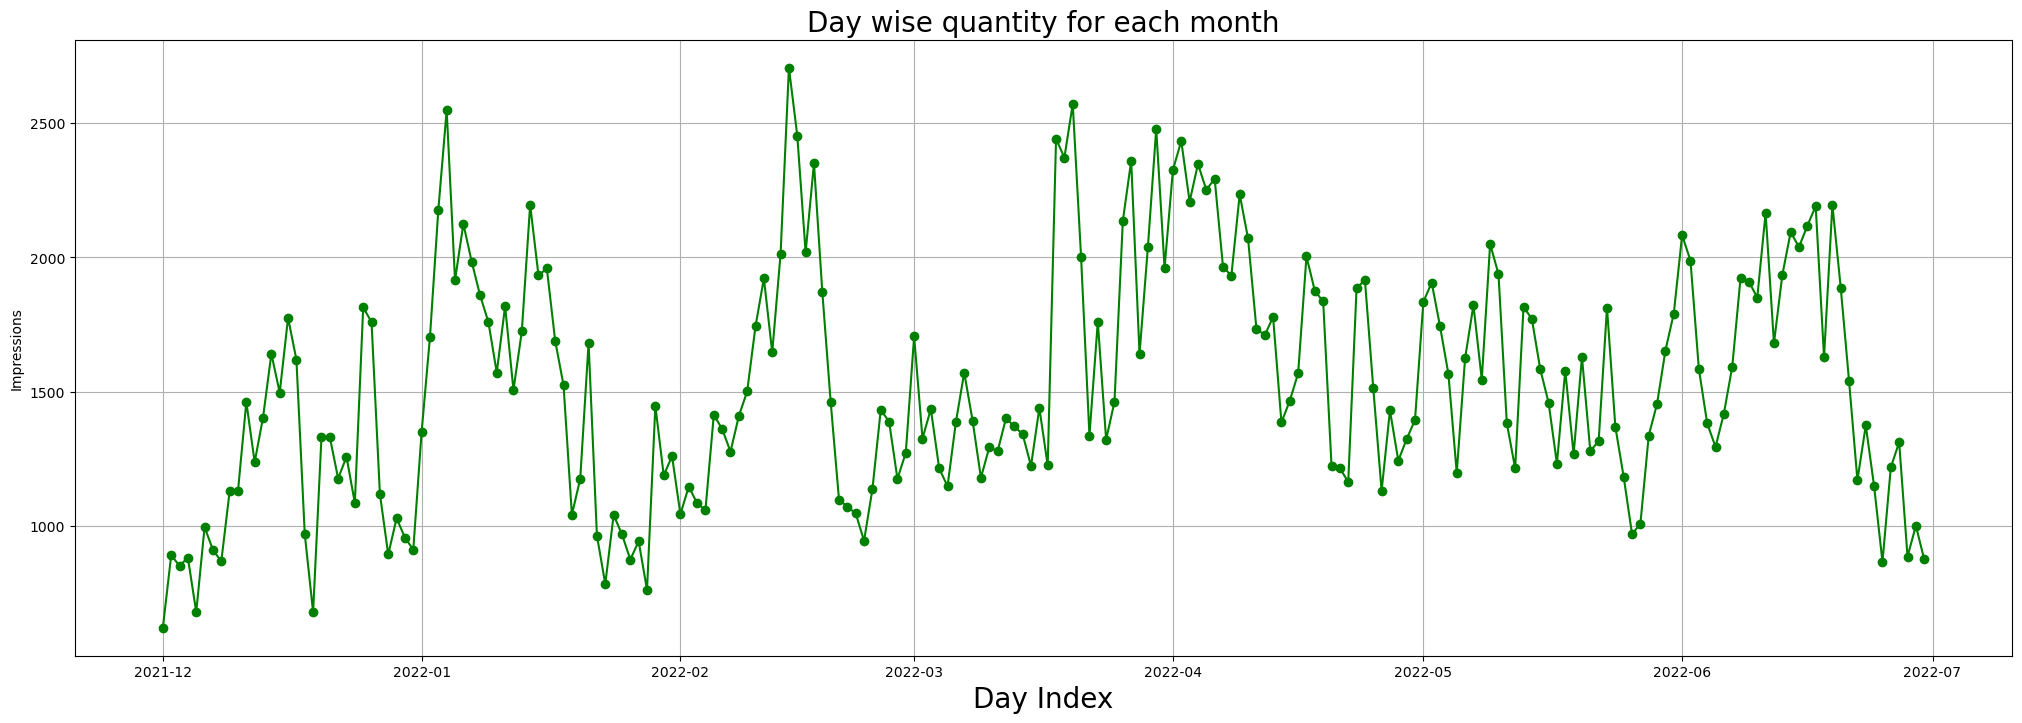

In [30]:
plt.figure(figsize=(25,8))
plt.plot(df['Day Index'],df['Impressions'],marker='o',c='g')
    
plt.title('Day wise quantity for each month',fontsize=20)
plt.xlabel('Day Index',fontsize=20)
plt.ylabel('Impressions')
plt.grid()
plt.show()  

    ➡️There are more peaks in the months of january and April. Highest impressions in February

### Analysing Monthly Data

In [31]:
monthly_data = df.groupby('Year-Month').agg({col: 'sum' for col in ['Quantity', 'Clicks', 'Impressions']}).reset_index()

monthly_data

,Year-Month,Quantity,Clicks,Impressions
0,2021-12,478.90,12284,35887
1,2022-01,533.00,12314,47464
2,2022-02,543.45,14372,42042
3,2022-03,615.45,15419,50803
4,2022-04,590.45,13480,52857
5,2022-05,471.00,4566,47325
6,2022-06,447.00,3504,48343


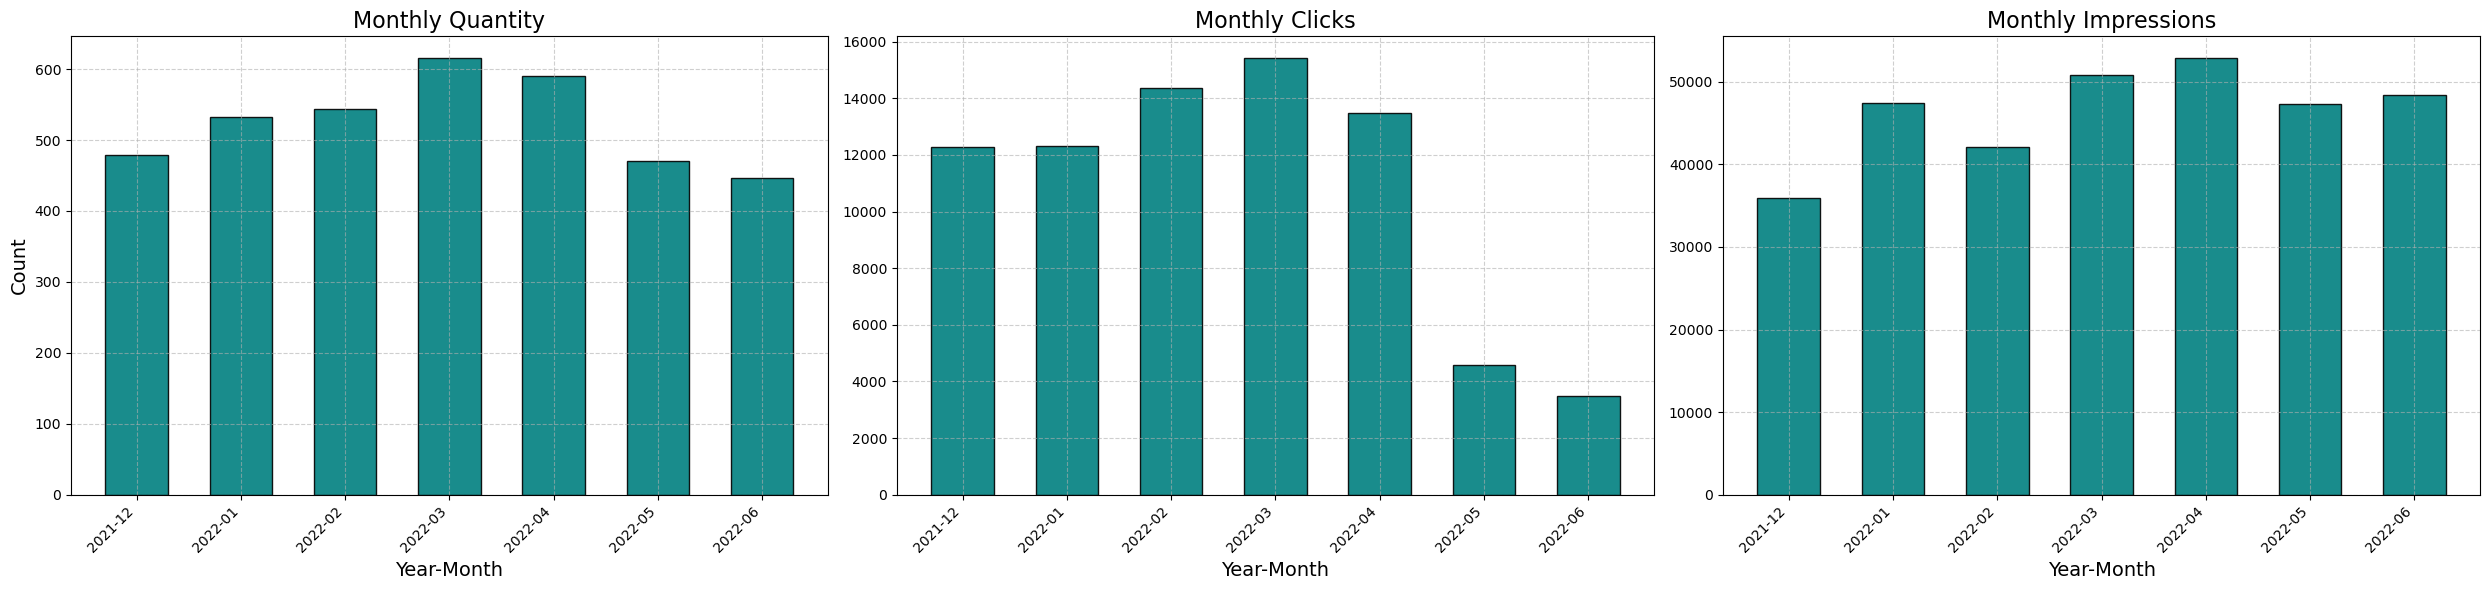

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6), sharey=False)

monthly_data['Year-Month'] = monthly_data['Year-Month'].astype(str)
columns = ['Quantity', 'Clicks', 'Impressions']
titles = ['Monthly Quantity', 'Monthly Clicks', 'Monthly Impressions']

for i, col in enumerate(columns):
    axes[i].bar(monthly_data['Year-Month'], monthly_data[col], color='teal', edgecolor='black', alpha=0.9, width=0.6)
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].set_xlabel('Year-Month', fontsize=14)
    axes[i].set_xticks(range(len(monthly_data['Year-Month'])))
    axes[i].set_xticklabels(monthly_data['Year-Month'], rotation=45, ha='right', fontsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[0].set_ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()


    ➡️Quantity, Clicks and Impressions are high in the month of March

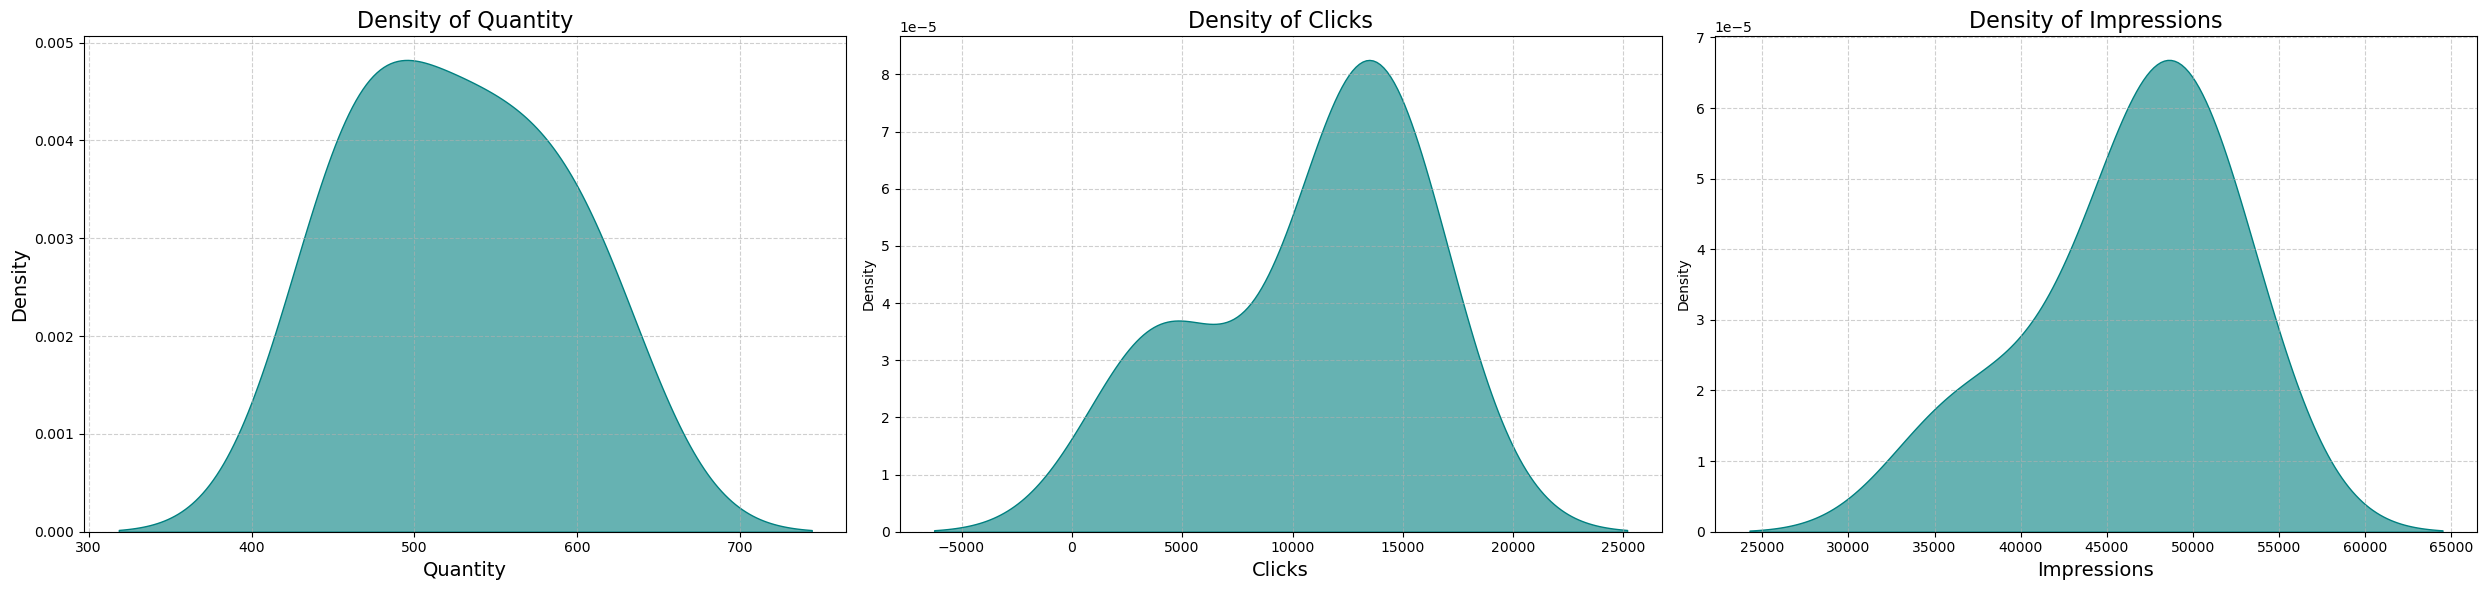

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(25, 6), sharey=False)

columns = ['Quantity', 'Clicks', 'Impressions']
titles = ['Density of Quantity', 'Density of Clicks', 'Density of Impressions']

for i, col in enumerate(columns):
    sns.kdeplot(monthly_data[col], ax=axes[i], fill=True, color='teal', alpha=0.6)
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[0].set_ylabel('Density', fontsize=14)

plt.tight_layout()
plt.show()


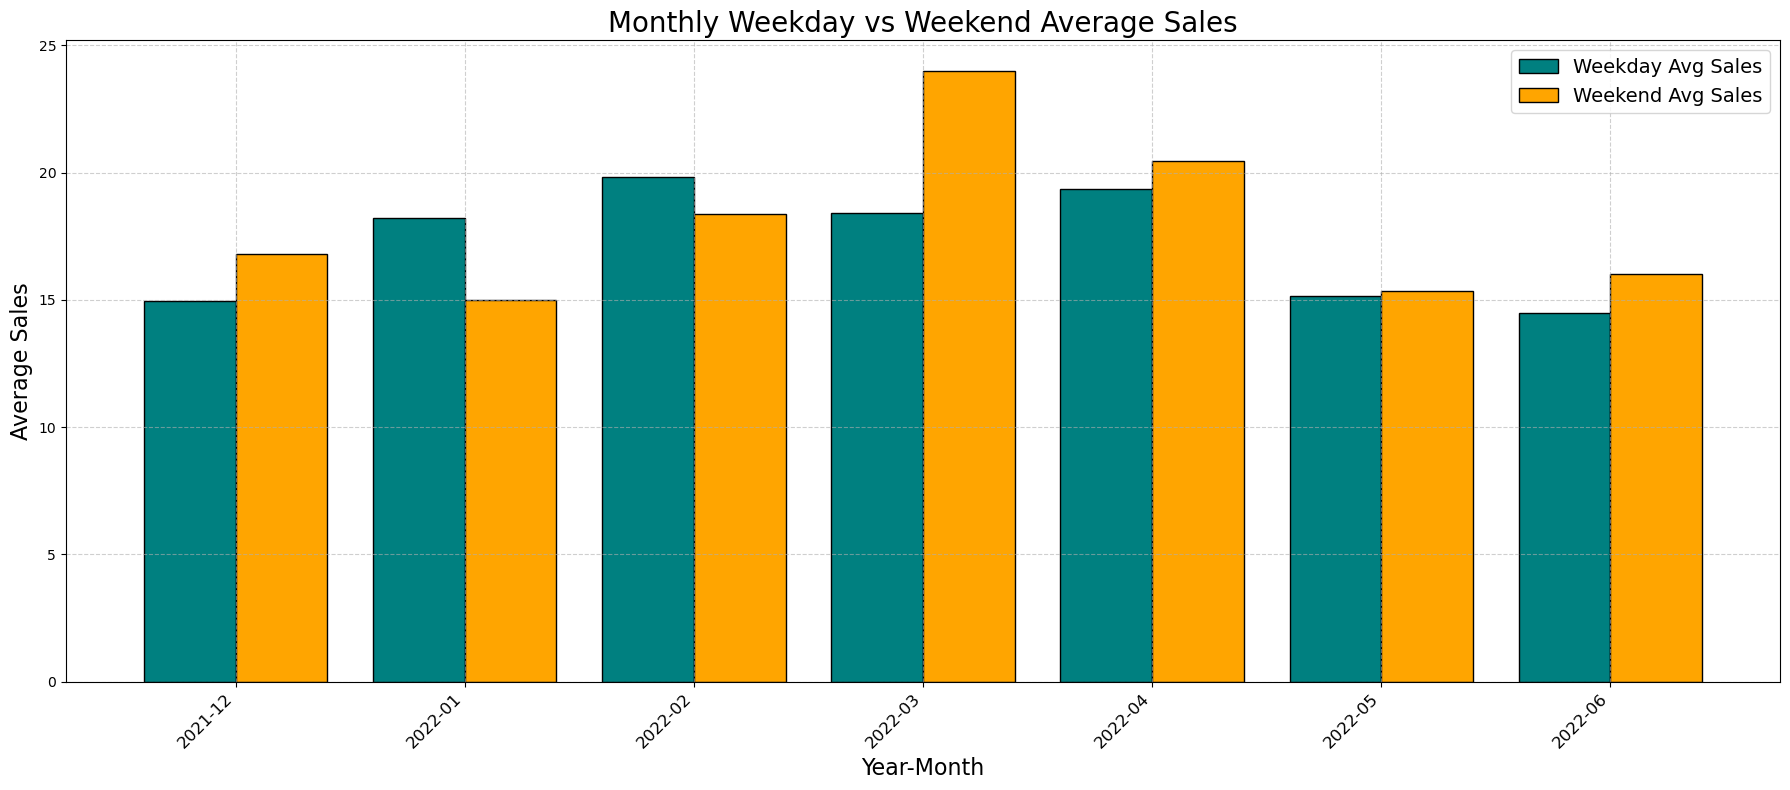

In [34]:
import matplotlib.pyplot as plt
import numpy as np

avg_sales = df.groupby(['Year-Month', 'Weekend'])['Quantity'].mean().unstack()

fig, ax = plt.subplots(figsize=(18, 8))
x_positions = np.arange(len(avg_sales))
bar_width = 0.4

ax.bar(x_positions - bar_width / 2, avg_sales[0], width=bar_width, label='Weekday Avg Sales', color='teal', edgecolor='black')
ax.bar(x_positions + bar_width / 2, avg_sales[1], width=bar_width, label='Weekend Avg Sales', color='orange', edgecolor='black')

ax.set_title('Monthly Weekday vs Weekend Average Sales', fontsize=20)
ax.set_xlabel('Year-Month', fontsize=16)
ax.set_ylabel('Average Sales', fontsize=16)
ax.set_xticks(x_positions)
ax.set_xticklabels(avg_sales.index, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


    ➡️Weekend average sales are more in 5 out of 7 months

### Day wise Analysis

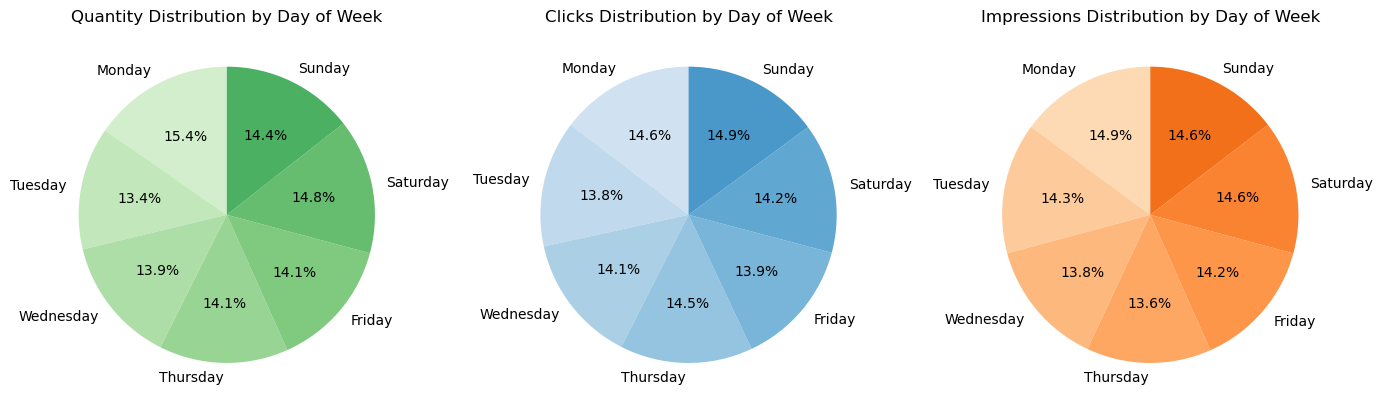

In [35]:
daywise_summary = df.groupby('Day_of_week').agg({
    'Quantity': 'sum',
    'Clicks': 'sum',
    'Impressions': 'sum'
}).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(14, 6))

green_colors = plt.cm.Greens(np.linspace(0.2, 0.6, len(daywise_summary)))
axes[0].pie(daywise_summary['Quantity'], labels=daywise_summary['Day_of_week'], autopct='%1.1f%%', startangle=90, colors=green_colors)
axes[0].set_title('Quantity Distribution by Day of Week')

blues_colors = plt.cm.Blues(np.linspace(0.2, 0.6, len(daywise_summary)))
axes[1].pie(daywise_summary['Clicks'], labels=daywise_summary['Day_of_week'], autopct='%1.1f%%', startangle=90, colors=blues_colors)
axes[1].set_title('Clicks Distribution by Day of Week')

orange_colors = plt.cm.Oranges(np.linspace(0.2, 0.6, len(daywise_summary)))
axes[2].pie(daywise_summary['Impressions'], labels=daywise_summary['Day_of_week'], autopct='%1.1f%%', startangle=90, colors=orange_colors)
axes[2].set_title('Impressions Distribution by Day of Week')

plt.tight_layout()
plt.show()

➡️Highest number of Sales on Monday<br>
➡️Highest number of Clicks on Sunday<br>
➡️Highest number of Impressions on Monday

## Week -3

## TIME SERIES MODELLING

### 10.Statistical Tests for Stationarity

In [36]:
#Augmented Dickey-Fuller (ADF) test

adftest = adfuller(df['Quantity'])
print('1. Test Statistic : ',adftest[0])
print('2. P-value: ',adftest[1])
print('3. Number of Lags : ',adftest[2])
print('4. Number of Observations used : ',adftest[3])
print('5. Critical values : ')

for i in adftest[4]:
    print("\t",i," : ",adftest[4][i])

if adftest[1] <= 0.05:
    print('\nReject the null hypothesis: The time series is stationary.')
else:
    print('Fail to reject the null hypothesis: The time series is non-stationary.')

1. Test Statistic :  -4.367385682143468
2. P-value:  0.0003388676203418857
3. Number of Lags :  3
4. Number of Observations used :  208
5. Critical values : 
	 1%  :  -3.4621857592784546
	 5%  :  -2.875537986778846
	 10%  :  -2.574231080806213

Reject the null hypothesis: The time series is stationary.


In [37]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
kpss_result = kpss(df['Quantity'])

print(f'Test Statistic: {kpss_result[0]}')
print(f'P-value: {kpss_result[1]}')
print(f'Number of Lags: {kpss_result[2]}')
print('Critical Values:')
for i in kpss_result[3]:
    print("\t",i," : ",kpss_result[3][i])
# Interpretation of the result
if kpss_result[1] > 0.05:
    print('\nFail to reject the null hypothesis: The time series is stationary.')
else:
    print('\nReject the null hypothesis: The time series is non-stationary.')


Test Statistic: 0.3377878133107644
P-value: 0.1
Number of Lags: 7
Critical Values:
	 10%  :  0.347
	 5%  :  0.463
	 2.5%  :  0.574
	 1%  :  0.739

Fail to reject the null hypothesis: The time series is stationary.


C:\Users\BHAVAJNA\AppData\Local\Temp\ipykernel_3292\45979898.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df['Quantity'])


### 11. Check for Autocorrelation

<Figure size 1000x600 with 0 Axes>

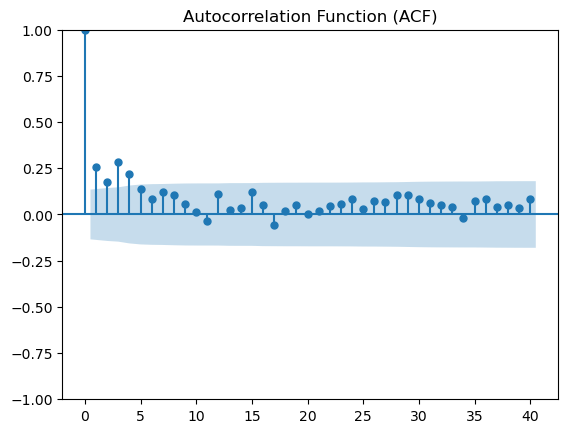

In [38]:
# Autocorrelation Function
plt.figure(figsize=(10, 6))
plot_acf(df['Quantity'], lags=40, alpha=0.05)  # Adjust lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

- ***Significant spike at lag 1***:
    The ACF shows a strong positive spike at lag 1, which suggests immediate autocorrelation in the data.<br></br>
    
- ***Gradual decay in subsequent lags***:
    The spikes decay over a few lags and eventually fall within the confidence interval. This behavior could indicate a short-term dependency in the data but not a persistent long-term correlation.<br></br>

- ***Some minor spikes beyond lag 1***:
    There are small spikes that exceed the confidence interval at lags 2, 3, and possibly a few more, suggesting potential noise or short-lived MA (Moving Average) effects.


<Figure size 1000x600 with 0 Axes>

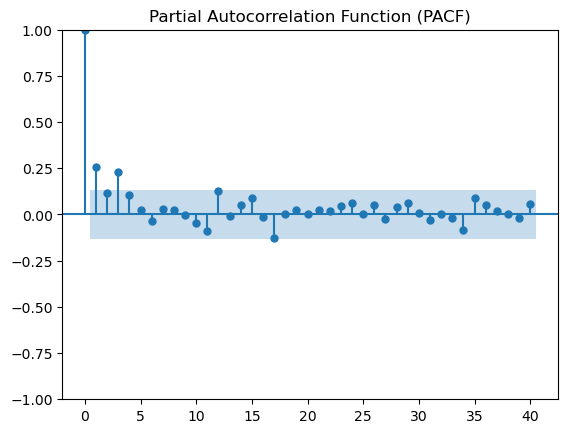

In [39]:
# Partial Autocorrelation Function
plt.figure(figsize=(10, 6))
plot_pacf(df['Quantity'], lags=40, alpha=0.05, method='ywm')  # Use method='ywm' for improved accuracy
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

- **Strong spike at lag 1**: The PACF shows a significant positive spike at lag 1, which exceeds the confidence interval.This indicates that the immediate past value (lag 1) has a strong influence on the current value.<br></br>

- **Subsequent lags**:After lag 1, most spikes fall within the confidence interval, indicating that higher-order lags do not have a significant partial correlation with the series.

### 12. Train - test split

In [40]:
train_size = int(len(df) * 0.7)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

y_train=train_data['Quantity']
y_test=test_data['Quantity']
y_dates=test_data['Day Index']
X_train=train_data.iloc[:,2:]
X_test=test_data.iloc[:,2:]

X_train=X_train.drop(['Year-Month','MonthName','Day_of_week'],axis=1)
X_test=X_test.drop(['Year-Month','MonthName','Day_of_week'],axis=1)
print(y_train)
# print(test_data)

0      14.00
1      10.00
2      13.00
3      22.00
4      27.45
       ...  
143    16.00
144    17.00
145    23.00
146    17.00
147    14.00
Name: Quantity, Length: 148, dtype: float64


## Auto Regression Model (AR)

In [41]:
model = AutoReg(y_train,lags=1)  # lags=1 means AR(1) model
model_fitted = model.fit()

forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
# print(f"Forecasted values: {forecast}")

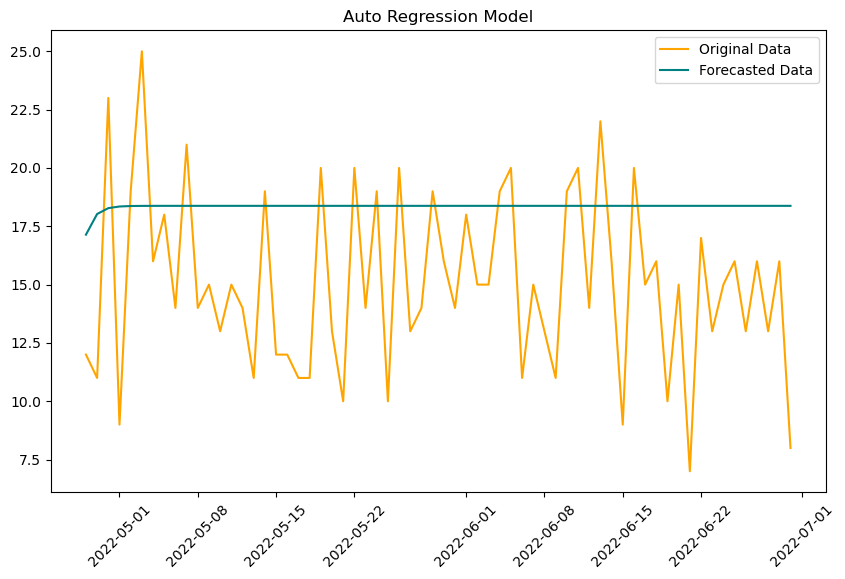

In [42]:
def plot_graph(model,forecast):
    plt.figure(figsize=(10, 6))
    plt.plot(y_dates,y_test, label='Original Data', color='orange')
    plt.plot(y_dates, forecast, label='Forecasted Data', color='teal')
    plt.title(model)
    plt.xticks(rotation=45)
    plt.legend()
    
plot_graph("Auto Regression Model",forecast)

In [43]:
def plot_graph_weekly(model, y_dates, y_test, forecast):
    y_dates = pd.to_datetime(y_dates)
    data = pd.DataFrame({'Date': y_dates, 'Original': y_test, 'Forecast': forecast}).set_index('Date')
    data = data.resample('W').mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Original'], label='Original Data', color='blue')
    plt.plot(data.index, data['Forecast'], label='Forecasted Data', color='magenta')
    plt.title(model)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:
best_lag = None
best_mse = float("inf")
best_forecast = None

# Try different lag values
for lag in range(1, 12):  # Adjust range as needed
    model = AutoReg(y_train, lags=lag)
    model_fitted = model.fit()
    
    # Generate forecast
    forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # Evaluate performance
    mse = mean_squared_error(y_test, forecast)
    if mse < best_mse:
        best_mse = mse
        best_lag = lag
        best_forecast = forecast

print(f"Optimal lag: {best_lag}, Best MSE: {best_mse}")

Optimal lag: 10, Best MSE: 23.815028499726523


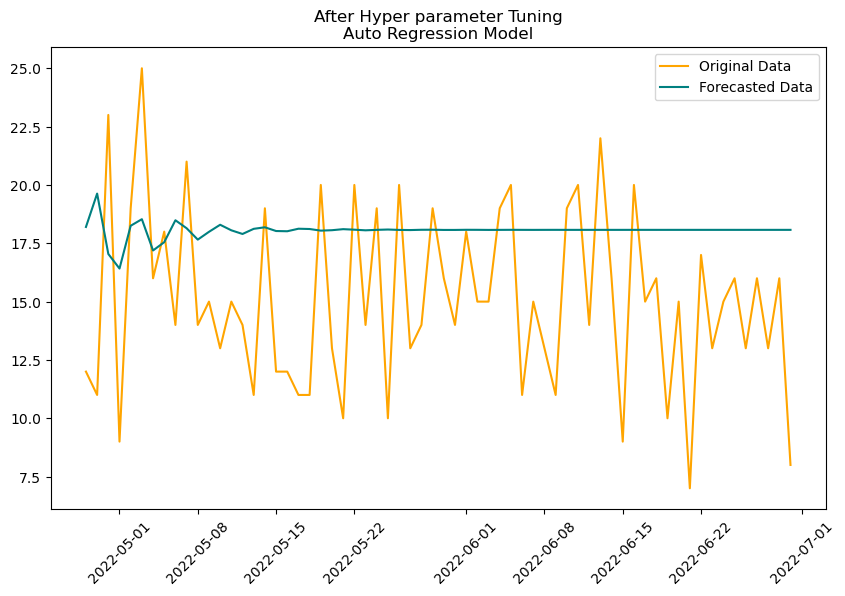

In [45]:
plot_graph("After Hyper parameter Tuning\nAuto Regression Model",best_forecast)

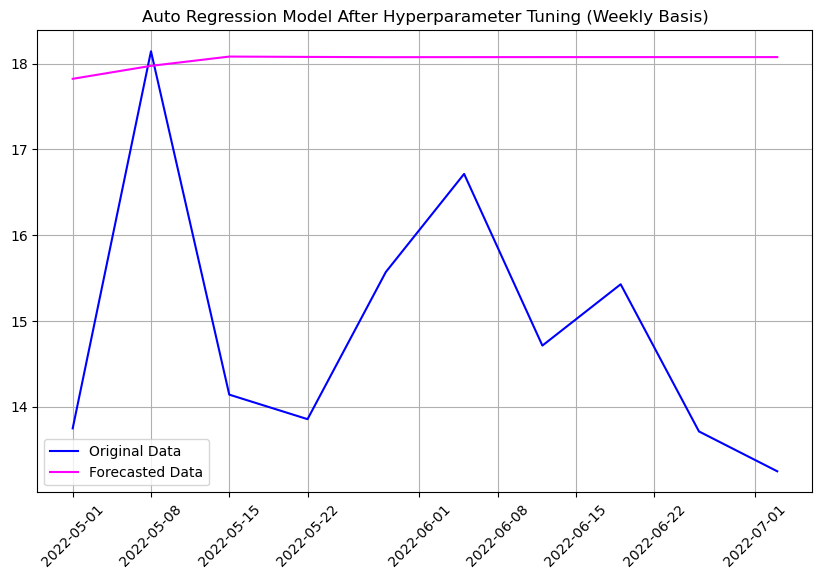

In [46]:
plot_graph_weekly("Auto Regression Model After Hyperparameter Tuning (Weekly Basis)", y_dates, y_test, best_forecast)

- Forecasted data appears relatively static, indicating poor adaptability to variations.

In [47]:
def metrics(model,forecast):
    mae = mean_absolute_error(y_test, forecast)
    mse = mean_squared_error(y_test,forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    return [model,mae,mse,rmse,mape]
    
AR = metrics("AR",best_forecast)

Mean Absolute Error (MAE): 4.126716433510001
Mean Squared Error (MSE): 23.815028499726523
Root Mean Squared Error (RMSE): 4.880064395038914
Mean Absolute Percentage Error (MAPE): 33.86%


## Moving Average Model(MA)

In [48]:
model = ARIMA(y_train, order=(0, 0, 1))
model_fitted = model.fit()

forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
print(forecast)

148    17.311237
149    18.334687
150    18.334687
151    18.334687
152    18.334687
         ...    
207    18.334687
208    18.334687
209    18.334687
210    18.334687
211    18.334687
Name: predicted_mean, Length: 64, dtype: float64


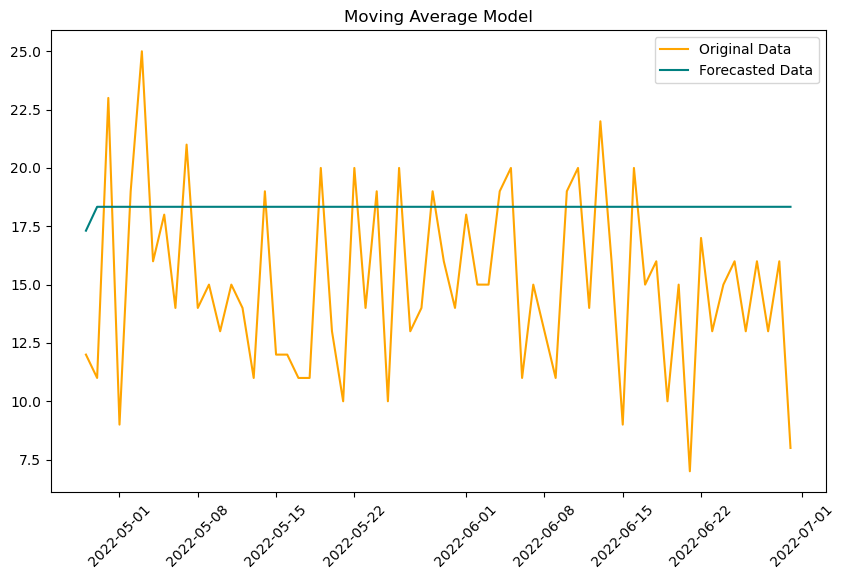

In [49]:
plot_graph("Moving Average Model",forecast)

In [50]:
best_order = None
best_mse = float("inf")
best_forecast = None

# Grid search for best (p, d, q)
for p in range(0, 1):
    for d in range(0, 1):
        for q in range(0, 5):
            try:
                model = ARIMA(y_train, order=(p, d, q))
                model_fitted = model.fit()
                
                forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
                
                mse = mean_squared_error(y_test, forecast)
                if mse < best_mse:
                    best_mse = mse
                    best_order = (p, d, q)
                    best_forecast = forecast
            except:
                continue

print(f"Best order: {best_order}, Best MSE: {best_mse}")

Best order: (0, 0, 4), Best MSE: 24.97887125023884


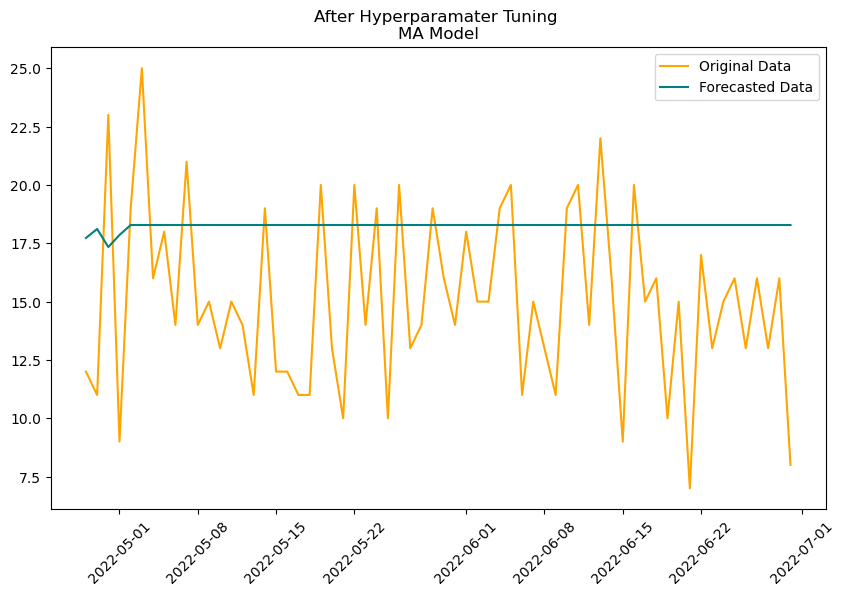

In [51]:
plot_graph("After Hyperparamater Tuning \nMA Model",best_forecast)

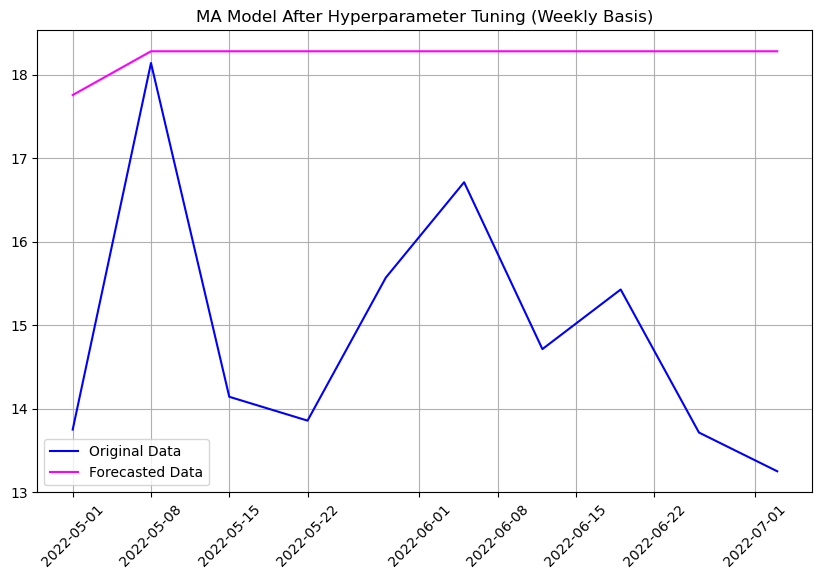

In [52]:
plot_graph_weekly("MA Model After Hyperparameter Tuning (Weekly Basis)", y_dates, y_test, best_forecast)

In [53]:
MA = metrics("MA",best_forecast)

Mean Absolute Error (MAE): 4.232221220090338
Mean Squared Error (MSE): 24.97887125023884
Root Mean Squared Error (RMSE): 4.99788667841107
Mean Absolute Percentage Error (MAPE): 34.81%


## ARIMA Model

In [54]:
p,d,q = 1,0,3
model = ARIMA(y_train, order=(p,d,q))
model_fitted = model.fit()

forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
print(forecast)

148    17.900348
149    17.934699
150    17.302134
151    17.593480
152    17.794921
         ...    
207    18.246275
208    18.246275
209    18.246275
210    18.246275
211    18.246275
Name: predicted_mean, Length: 64, dtype: float64


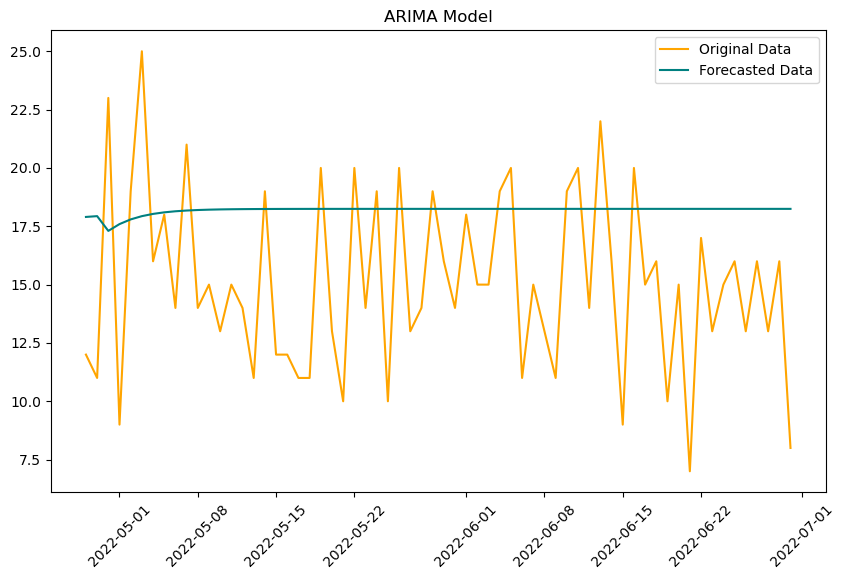

In [55]:
plot_graph("ARIMA Model",forecast)

In [56]:
best_order = None
best_mse = float("inf")
best_forecast = None
residuals = None

# Grid search over (p, d, q)
for p in range(0, 5):
    for d in range(0, 1):
        for q in range(0, 5):
            try:
                # Fit ARIMA model
                model = ARIMA(y_train, order=(p, d, q))
                model_fitted = model.fit()
                
                # Generate forecast
                forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
                
                # Calculate MSE
                mse = mean_squared_error(y_test, forecast)
                if mse < best_mse:
                    best_mse = mse
                    best_order = (p, d, q)
                    best_forecast = forecast
                    residuals = model_fitted.resid
            except:
                continue

# Print the best parameters and MSE
print(f"Best ARIMA Order: {best_order}, Best MSE: {best_mse}")

C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\BHAVAJNA\anaconda3

Best ARIMA Order: (4, 0, 2), Best MSE: 24.63252754891637


C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


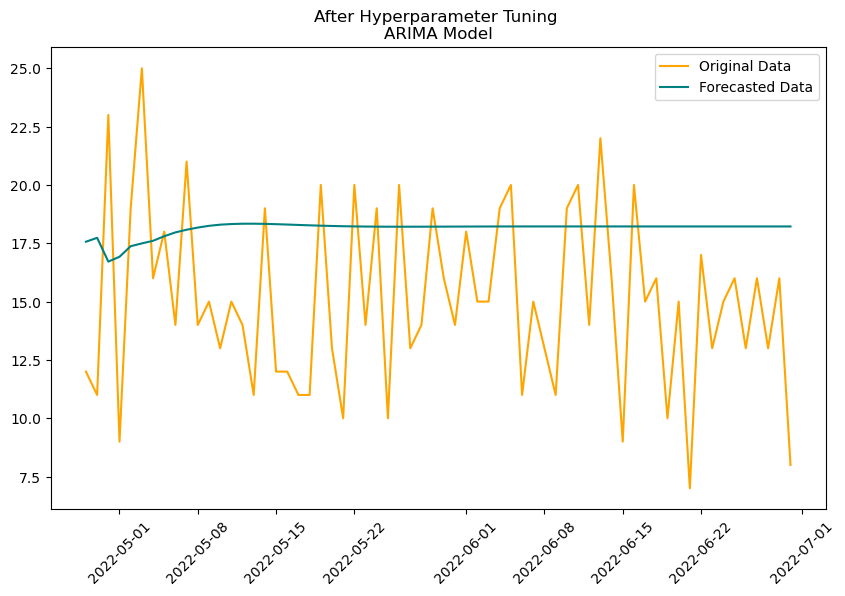

In [57]:
plot_graph("After Hyperparameter Tuning \nARIMA Model",best_forecast)

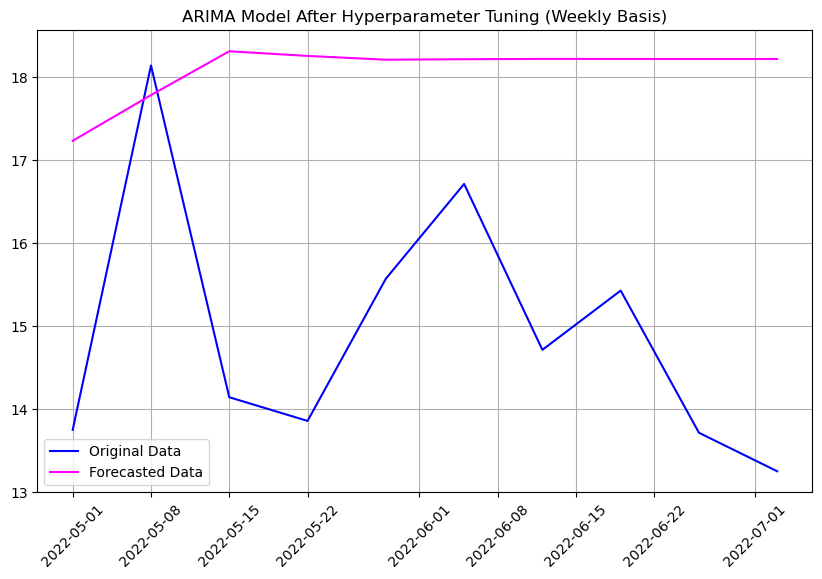

In [58]:
plot_graph_weekly("ARIMA Model After Hyperparameter Tuning (Weekly Basis)", y_dates, y_test, best_forecast)

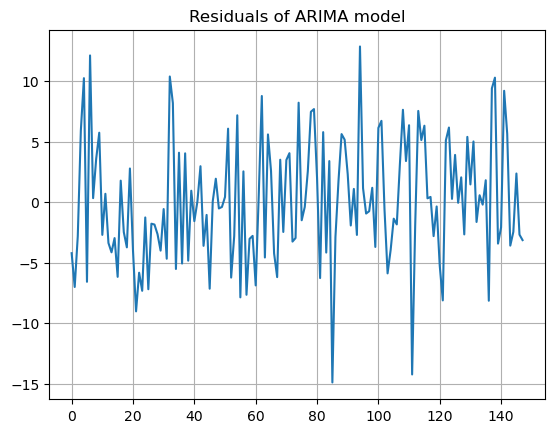

In [59]:
# Plot residuals
plt.plot(residuals)
plt.title("Residuals of ARIMA model")
plt.grid(True)
plt.show()

In [60]:
ARIMA = metrics("ARIMA",best_forecast)

Mean Absolute Error (MAE): 4.21108101254772
Mean Squared Error (MSE): 24.63252754891637
Root Mean Squared Error (RMSE): 4.963116717236899
Mean Absolute Percentage Error (MAPE): 34.46%


## SARIMA Model

In [61]:
model = SARIMAX(y_train, order=(1,0,3), seasonal_order=(1, 1, 1, 12))
model_fitted = model.fit()

forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
print(forecast)

148    17.589278
149    22.271315
150    21.873771
151    17.926952
152    18.076903
         ...    
207    17.114792
208    16.754955
209    22.746545
210    23.041209
211    18.173677
Name: predicted_mean, Length: 64, dtype: float64


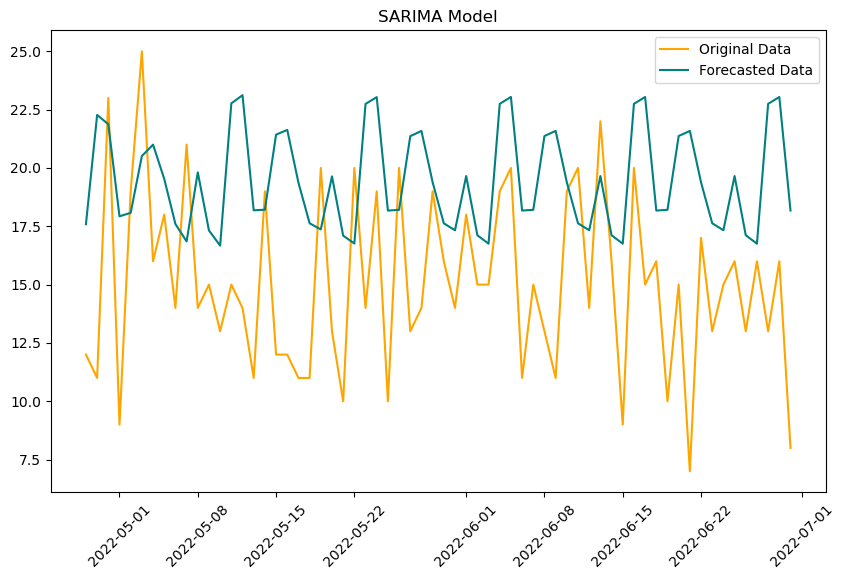

In [62]:
plot_graph("SARIMA Model",forecast)

In [63]:
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
p, d, q = range(1,3), range(1), range(1,4)
P, D, Q, s = range(2), range(2), range(2), 12

best_order, best_seasonal, best_mse = None, None, float("inf")
for i in p:
    for j in d:
        for k in q:
            for I in P:
                for J in D:
                    for K in Q:
                        try:
                            model = SARIMAX(y_train, order=(i, j, k), seasonal_order=(I, J, K, s)).fit(disp=False)
                            forecast = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
                            mse = mean_squared_error(y_test, forecast)
                            if mse < best_mse:
                                best_mse, best_order, best_seasonal, best_forecast = mse, (i, j, k), (I, J, K, s), forecast
                                residuals = model_fitted.resid
                        except:
                            continue

print(f"Best Order: {best_order}, Seasonal: {best_seasonal}, MSE: {best_mse}")

C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\BHAVAJNA\anaconda3\

Best Order: (1, 0, 1), Seasonal: (0, 0, 0, 12), MSE: 22.70980665172904


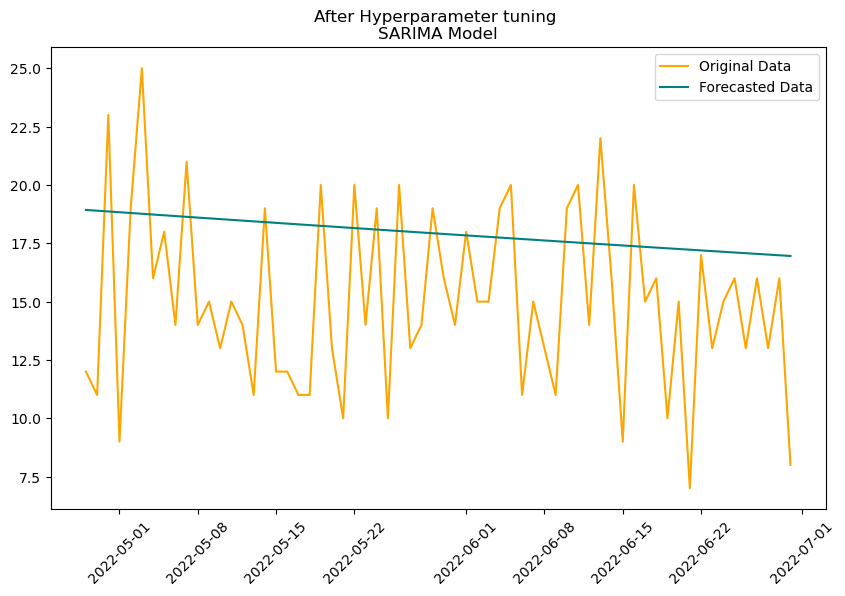

In [64]:
plot_graph("After Hyperparameter tuning \nSARIMA Model",best_forecast)

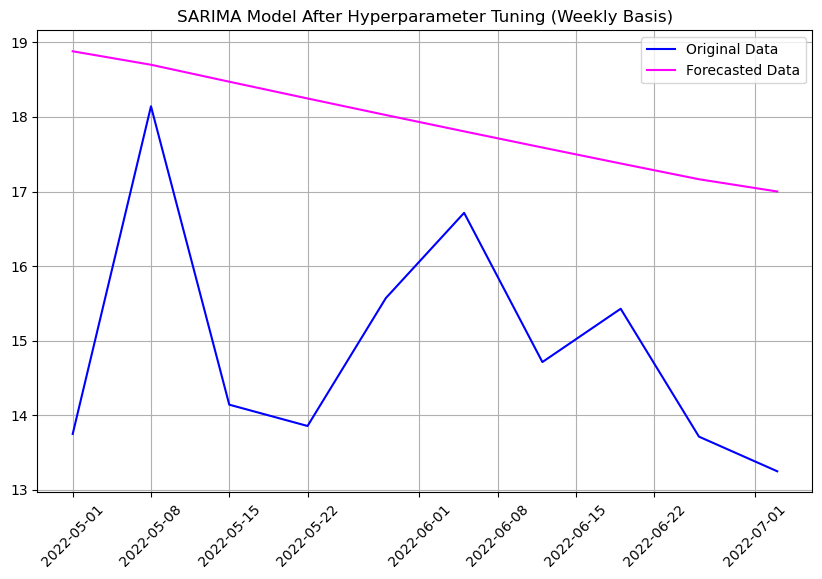

In [65]:
plot_graph_weekly("SARIMA Model After Hyperparameter Tuning (Weekly Basis)", y_dates, y_test, best_forecast)

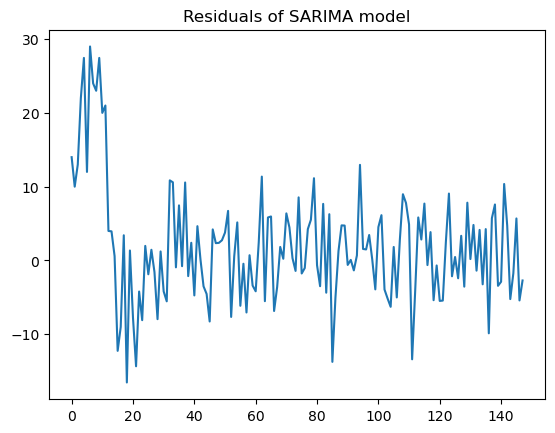

In [66]:
# Plot residuals
plt.plot(residuals)
plt.title("Residuals of SARIMA model")
plt.show()

In [67]:
SARIMA = metrics("SARIMA",best_forecast)

Mean Absolute Error (MAE): 3.9830958665123637
Mean Squared Error (MSE): 22.70980665172904
Root Mean Squared Error (RMSE): 4.765480736686388
Mean Absolute Percentage Error (MAPE): 32.79%


## ARIMAX Model

In [68]:
model = SARIMAX(y_train, exog=X_train, order=(1,0,3))
model_fitted = model.fit()

forecast = model_fitted.forecast(steps=len(y_test), exog=X_test)
# print(model_fitted.summary())
print(forecast)

148    13.320488
149    14.643686
150    15.678299
151    16.080567
152    15.676215
         ...    
207    11.069511
208    12.268535
209     8.902202
210     8.895502
211     8.558343
Name: predicted_mean, Length: 64, dtype: float64


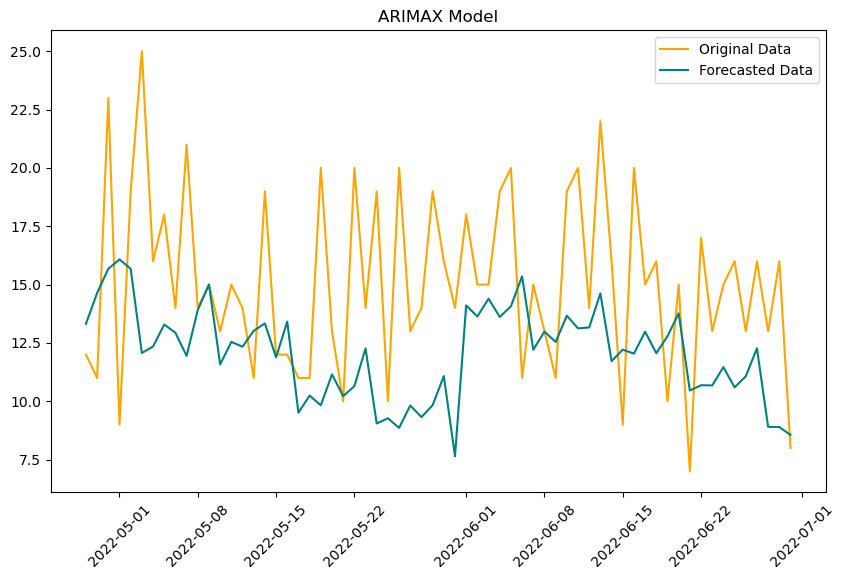

In [69]:
plot_graph("ARIMAX Model",forecast)

In [70]:
p, d, q = range(5), range(2), range(5)

best_order, best_mse, best_forecast = None, float("inf"), None

# Grid search for (p, d, q)
for i in p:
    for j in d:
        for k in q:
            try:
                model = SARIMAX(y_train, exog=X_train, order=(i, j, k))
                model_fitted = model.fit(disp=False)
                forecast = model_fitted.forecast(steps=len(y_test), exog=X_test)
                mse = mean_squared_error(y_test, forecast)
                if mse < best_mse:
                    best_mse, best_order, best_forecast = mse, (i, j, k), forecast
                    residuals = model_fitted.resid
            except:
                continue

print(f"Best Order: {best_order}, Best MSE: {best_mse}")

Best Order: (4, 1, 0), Best MSE: 15.462824996281737


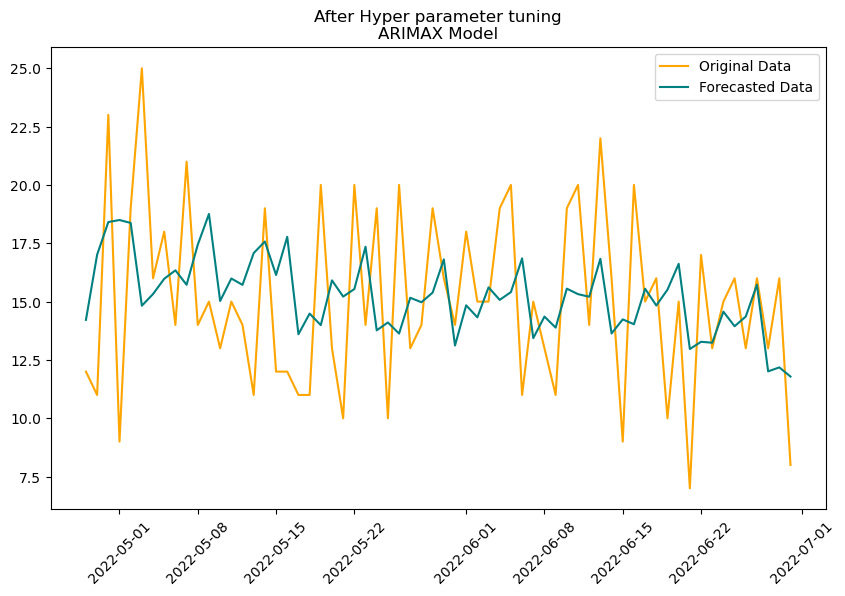

In [71]:
plot_graph("After Hyper parameter tuning\nARIMAX Model",best_forecast)

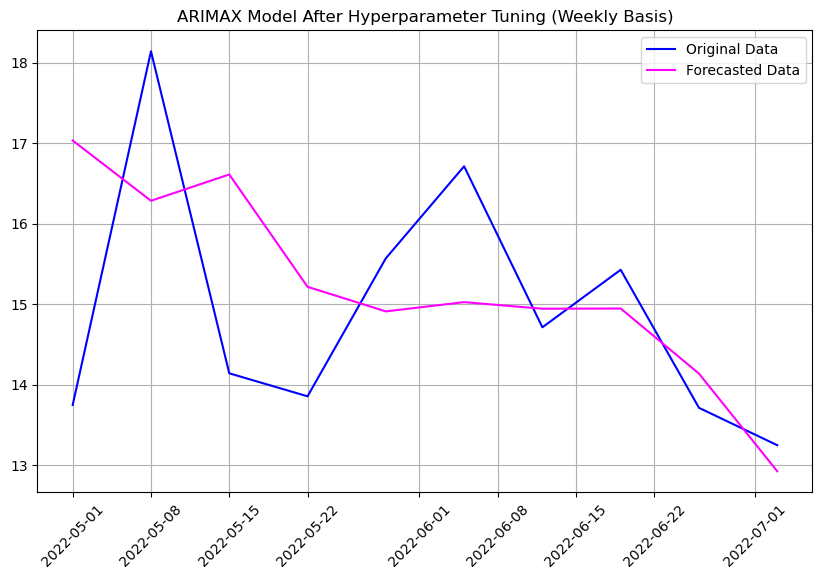

In [72]:
plot_graph_weekly("ARIMAX Model After Hyperparameter Tuning (Weekly Basis)", y_dates, y_test, best_forecast)

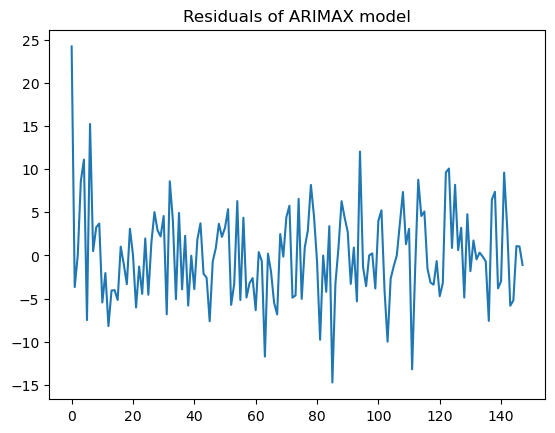

In [73]:
# Plot residuals
plt.plot(residuals)
plt.title("Residuals of ARIMAX model")
plt.show()

In [74]:
ARIMAX = metrics("ARIMAX",best_forecast)

Mean Absolute Error (MAE): 3.2682094076406596
Mean Squared Error (MSE): 15.462824996281737
Root Mean Squared Error (RMSE): 3.93227987257796
Mean Absolute Percentage Error (MAPE): 23.89%


## SARIMAX Model

In [75]:
model = SARIMAX(y_train, exog=X_train, order=(1,0,3),seasonal_order=(1,1,1,12))
model_fitted = model.fit()

forecast = model_fitted.forecast(steps=len(y_test), exog=X_test)
# print(model_fitted.summary())
print(forecast)

148    10.753850
149    16.816431
150    17.603334
151    18.456125
152    17.606740
         ...    
207    12.303787
208    11.631258
209    15.183231
210    14.795550
211     9.640049
Name: predicted_mean, Length: 64, dtype: float64


Mean Absolute Error (MAE): 3.5940935430902705
Mean Squared Error (MSE): 19.605083404307972
Root Mean Squared Error (RMSE): 4.427762799011254
Mean Absolute Percentage Error (MAPE): 25.95%


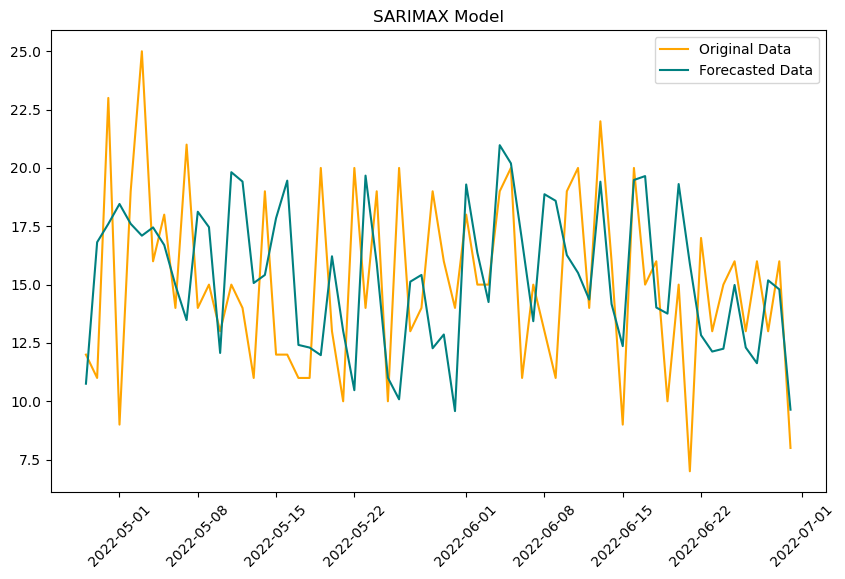

In [76]:
plot_graph("SARIMAX Model",forecast)
SARIMAX_before = metrics("SARIMAX",forecast)

In [77]:
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
p, d, q = range(1,5), range(1), range(1,3)
P, D, Q, s = range(2), range(2), range(2), 12
best_order, best_seasonal, best_mse, best_forecast = None, None, float("inf"), None

for i in p:
    for j in d:
        for k in q:
            for I in P:
                for J in D:
                    for K in Q:
                        try:
                            model = SARIMAX(y_train, exog=X_train, order=(i, j, k), seasonal_order=(I, J, K, s)).fit(disp=False)
                            forecast = model.forecast(steps=len(y_test), exog=X_test)
                            mse = mean_squared_error(y_test, forecast)
                            if mse < best_mse:
                                best_mse, best_order, best_seasonal, best_forecast = mse, (i, j, k), (I, J, K, s), forecast
                                residuals = model_fitted.resid
                        except:
                            continue

print(f"Best Order: {best_order}, Seasonal: {best_seasonal}, MSE: {best_mse}")

Best Order: (2, 0, 2), Seasonal: (0, 1, 1, 12), MSE: 17.754410913059182


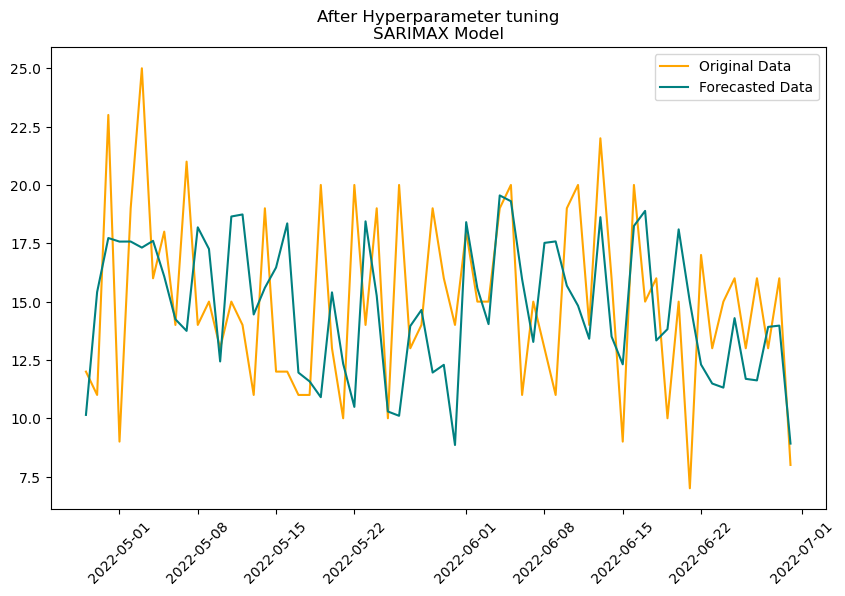

In [78]:
plot_graph("After Hyperparameter tuning\nSARIMAX Model",best_forecast)

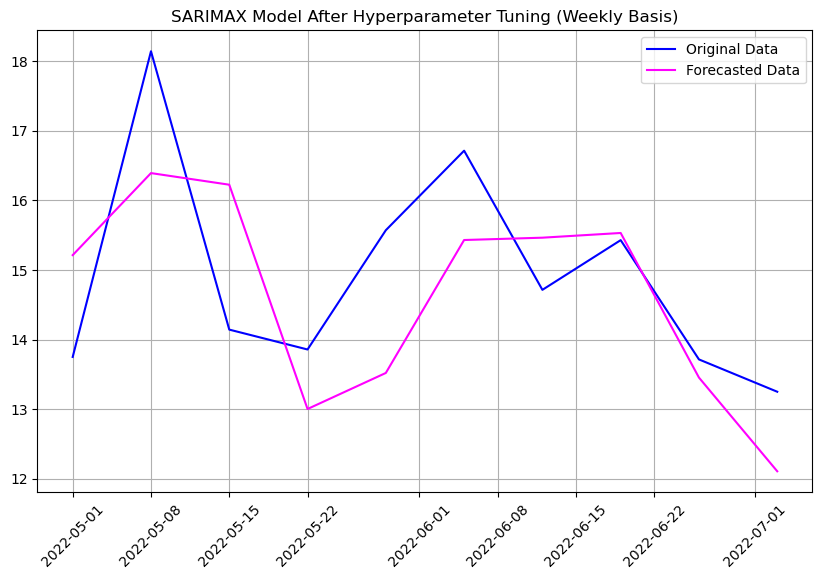

In [79]:
plot_graph_weekly("SARIMAX Model After Hyperparameter Tuning (Weekly Basis)", y_dates, y_test, best_forecast)

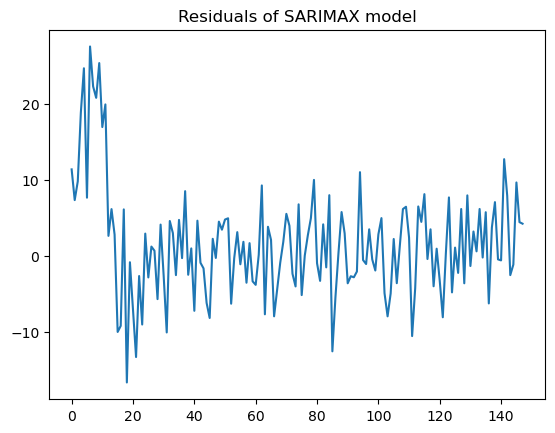

In [80]:
# Plot residuals
plt.plot(residuals)
plt.title("Residuals of SARIMAX model")
plt.show()

In [81]:
SARIMAX = metrics("SARIMAX",best_forecast)

Mean Absolute Error (MAE): 3.400912900694011
Mean Squared Error (MSE): 17.754410913059182
Root Mean Squared Error (RMSE): 4.213598333142254
Mean Absolute Percentage Error (MAPE): 23.91%


In [82]:
comparision = pd.DataFrame({
    "Model": [AR[0], MA[0], ARIMA[0], SARIMA[0], ARIMAX[0], SARIMAX[0]],
    "MAE": [AR[1], MA[1], ARIMA[1], SARIMA[1], ARIMAX[1], SARIMAX[1]],
    "MSE": [AR[2], MA[2], ARIMA[2], SARIMA[2], ARIMAX[2], SARIMAX[2]],
    "RMSE": [AR[3], MA[3], ARIMA[3], SARIMA[3], ARIMAX[3], SARIMAX[3]],
    "MAPE": [AR[4], MA[4], ARIMA[4], SARIMA[4], ARIMAX[4], SARIMAX[4]],
})

print("Evaluation Metrics: \n")
print(comparision)

Evaluation Metrics: 

     Model       MAE        MSE      RMSE       MAPE
0       AR  4.126716  23.815028  4.880064  33.859181
1       MA  4.232221  24.978871  4.997887  34.809350
2    ARIMA  4.211081  24.632528  4.963117  34.458835
3   SARIMA  3.983096  22.709807  4.765481  32.793618
4   ARIMAX  3.268209  15.462825  3.932280  23.893145
5  SARIMAX  3.400913  17.754411  4.213598  23.908555


    => ARIMAX is the better Model considering RMSE & MSE metrics

## Week - 4

# MULTIVARIATE ANALYSIS

In [83]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
SSR = np.sum((y_pred - np.mean(y_test)) ** 2)
SST = np.sum((y_test.values - np.mean(y_test)) ** 2)
r2_score = SSR/SST

# print("Coefficients:", model.coef_)
# print("Intercept:", model.intercept_)

Mean Squared Error: 18.09822766805329
Root Mean Squared Error: 4.254201178606071
R2 Score: 0.38658973147304687
Mean Absolute Error (MAE): 3.3260607328636027
Mean Squared Error (MSE): 18.09822766805329
Root Mean Squared Error (RMSE): 4.254201178606071
Mean Absolute Percentage Error (MAPE): 21.98%


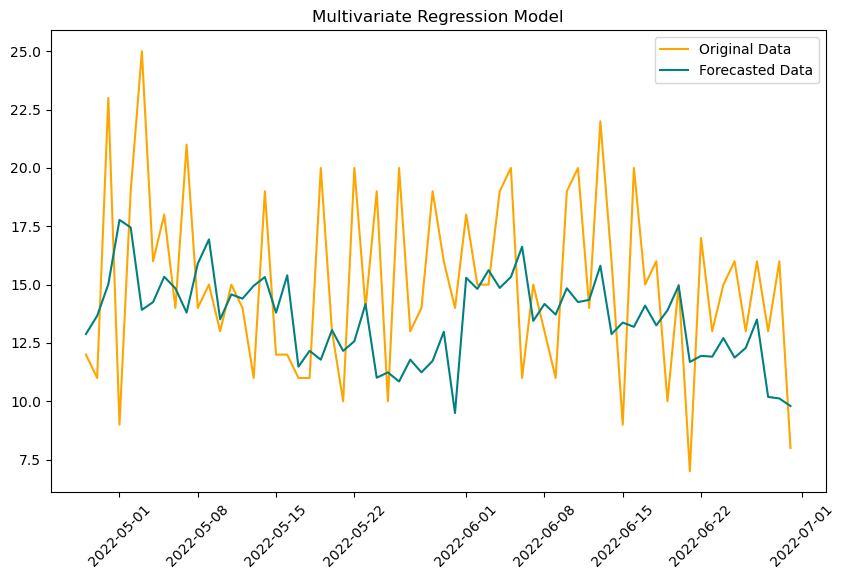

In [84]:
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score)

results = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
multiVariate = metrics("MultiVariate",y_pred)
# print(results)
plot_graph("Multivariate Regression Model",y_pred)

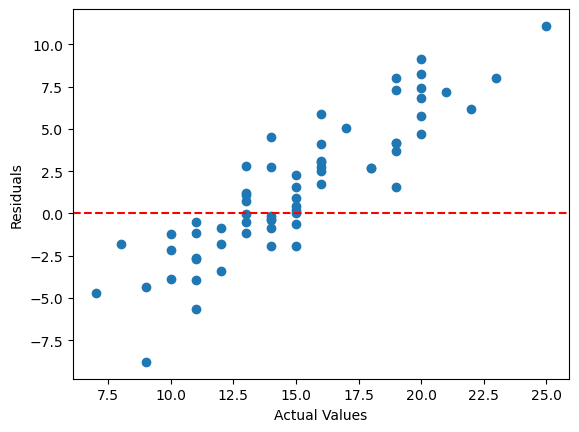

In [85]:
residuals = y_test - model.predict(X_test)
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()


## Hyper Parameter Tuning 

Best alpha: 100
Best Model: Ridge(alpha=100)
RMSE: 4.761116100652357


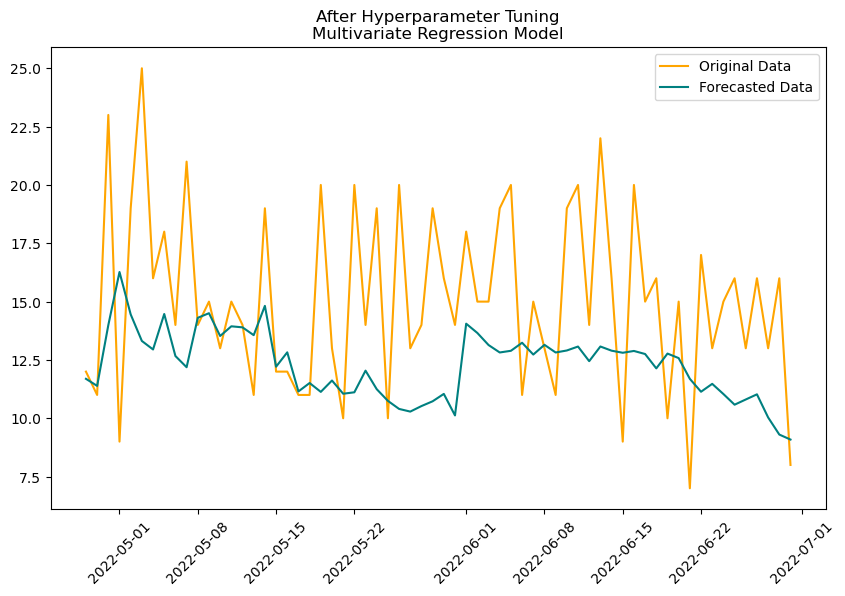

In [86]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the Ridge model
ridge = Ridge()

# Define the hyperparameter grid
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

print(f"Best alpha: {best_alpha}")
print(f"Best Model: {best_model}")
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Create a DataFrame for easier visualization (optional)
forecast_df = pd.DataFrame({'Actual': y_test, 'Forecast': y_pred}, index=X_test.index)

plot_graph("After Hyperparameter Tuning\nMultivariate Regression Model",forecast_df['Forecast'])

In [87]:
comparision = pd.DataFrame({
    "Model": [AR[0], MA[0], ARIMA[0], SARIMA[0], ARIMAX[0], SARIMAX[0],multiVariate[0]],
    "MAE": [AR[1], MA[1], ARIMA[1], SARIMA[1], ARIMAX[1], SARIMAX[1],multiVariate[1]],
    "MSE": [AR[2], MA[2], ARIMA[2], SARIMA[2], ARIMAX[2], SARIMAX[2],multiVariate[2]],
    "RMSE": [AR[3], MA[3], ARIMA[3], SARIMA[3], ARIMAX[3], SARIMAX[3],multiVariate[3]],
    "MAPE": [AR[4], MA[4], ARIMA[4], SARIMA[4], ARIMAX[4], SARIMAX[4],multiVariate[4]],
})

print("Evaluation Metrics: \n")
print(comparision)

Evaluation Metrics: 

          Model       MAE        MSE      RMSE       MAPE
0            AR  4.126716  23.815028  4.880064  33.859181
1            MA  4.232221  24.978871  4.997887  34.809350
2         ARIMA  4.211081  24.632528  4.963117  34.458835
3        SARIMA  3.983096  22.709807  4.765481  32.793618
4        ARIMAX  3.268209  15.462825  3.932280  23.893145
5       SARIMAX  3.400913  17.754411  4.213598  23.908555
6  MultiVariate  3.326061  18.098228  4.254201  21.975575


ARIMAX is the best model based on RMSE and other Metrics